# SEGMENT GPS Analysis

##### Notes
UTM  36North
EPSG:32636

In [2]:
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.dates as pltdate
from matplotlib.ticker import FixedLocator

import numpy as np
import os

import pandas as pd
import geopandas as gpd

import gpstools as gps

from shapely.geometry import LinearRing

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#from cartopy.io import LocatedImage
#from cartopy.io.shapereader import Reader
from cartopy.io.img_tiles import MapboxTiles

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%qtconsole
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 24 #GSA presentation

In [4]:
# Read list of SEGMENT & Nearby stations
df = pd.read_csv('segment_gps.txt',header=None, names=['site'])
seg_sites = list(df.site)
#NOTE: 'KARO' identifier already used in Australia

# Read list of SEGMENT stations
df = pd.read_csv('other_gps.txt',header=None, names=['site'])
other_sites = list(df.site)

In [5]:
dfS = gps.io.ungl.load_stations()
dfS.head()

site      lat       lon   height      start        end
0  00NA -12.4666  130.8440  104.851 2008-03-27 2017-10-07
1  01NA -12.4782  130.9820  105.409 2008-04-08 2017-10-07
2  02NA -12.3559  130.8817  117.652 2008-09-22 2016-12-31
3  1LSU  30.4074  -91.1803   -6.487 2003-04-23 2017-10-07
4  1NSU  31.7508  -93.0976   28.071 2004-01-16 2017-10-07

In [12]:
dfSeg = dfS[dfS.site.isin(seg_sites)]
dfSeg.to_csv('segment_sites.csv', index=False)
gfSeg = gps.io.toGeoDataFrame(dfSeg)

dfOther = dfS[dfS.site.isin(other_sites)]
dfOther.to_csv('other_sites.csv', index=False)
gfOther = gps.io.toGeoDataFrame(dfOther)

In [57]:
### 31 Dec. 2014 Mw 5.1 
#pSegment = np.array([33.8451, -9.86088])
pSegment = np.array([33.836, -9.871]) #final values from Sarah
pNEIC = np.array([33.863, -10.027]) 
pCMT = np.array([33.79, -9.73]) 

In [58]:
dfM = gps.io.ungl.load_midas()

In [59]:
dfM.head()

site version      start        end    years  epochs  epochs_good  pairs  \
0  00NA  MIDAS4  2008.2355  2017.7467   9.5112    2800         2559   4579   
1  01NA  MIDAS4  2008.2683  2017.7467   9.4784    1673         1668   2896   
2  02NA  MIDAS4  2008.7255  2016.9993   8.2738    1906         1906   3378   
3  1LSU  MIDAS4  2003.3073  2017.7467  14.4394    4530         4006   5420   
4  1NSU  MIDAS4  2004.0411  2017.7467  13.7056    4565         4263   6496   

     east   north   ...       e0     n0      u0  out_e  out_n  out_u  sig_e  \
0  35.746  58.472   ...    0.202  1.527  14.313  0.077  0.074  0.084  2.927   
1  35.560  59.437   ...    0.424  2.198 -13.879  0.118  0.125  0.121  2.133   
2  35.889  59.791   ...   -4.092  1.212  -6.671  0.087  0.073  0.081  2.503   
3 -12.984  -0.383   ...    4.305 -3.609  -4.235  0.052  0.056  0.064  4.507   
4 -13.251  -0.225   ...   -2.563  1.530   0.765  0.069  0.055  0.056  2.343   

   sig_n   sig_u  nsteps  
0  3.134   9.206       2  
1  1.965   7.468       1  
2  2.768   8.395       0  
3  3.304  10.396       7  
4  2.329   9.059       3  

[5 rows x 24 columns]

In [60]:
dfM.keys()

Index(['site', 'version', 'start', 'end', 'years', 'epochs', 'epochs_good',
       'pairs', 'east', 'north', 'up', 'err_e', 'err_n', 'err_u', 'e0', 'n0',
       'u0', 'out_e', 'out_n', 'out_u', 'sig_e', 'sig_n', 'sig_u', 'nsteps'],
      dtype='object')

## Extract Station between certain lat-lon range

In [61]:
subset = dfS.query('(-16 < lat < -6) and (30 < lon < 40)') #Extend East to get subandes stations
df = pd.merge(dfM, subset, how='inner', on=['site'])
# Additional subset to get same time range as PLUTONS stations
#df.query('(start >= 2010.2861) and (end <= 2015.1951)') #UTUR
# Doesn't work,,, for interseismic analysis consider UTUR start up to Pisagua EQ, however, MIDAS
# supposedly is insensitive to offsets, or actually removes them based on events in steps database

In [62]:
def crop_to_map(ax, gframe):
    ''' crop geopandas dataframe to map area'''
    minLon, maxLon, minLat, maxLat = ax.get_extent()
    gframe['lon'] = gframe.geometry.apply(lambda p: p.x)
    gframe['lat'] = gframe.geometry.apply(lambda p: p.y)
    crop = gframe.query('(@minLat < lat < @maxLat) and (@minLon < lon < @maxLon)') 
    return crop

In [12]:
def add_points_to_map(ax, gf, point=True, label=True, text='NAME', 
                      scatterArgs=dict(marker='o', c='k', s=10),
                      textArgs=dict(fontweight='normal')):
    ''' Assume Geodetic Lat/Lon'''
    
    crop = crop_to_map(ax,gf)
    
    if point:
        points = list(crop.geometry)
        lats = [point.y for point in points]
        lons = [point.x for point in points]
        ax.scatter(lons, lats, zorder=10, transform=ccrs.Geodetic(), 
                   **scatterArgs) 

    if label:
        for i,row in crop.iterrows():
            ax.text(row.geometry.x, row.geometry.y, row[text], transform=ccrs.Geodetic(),
                   **textArgs)


In [13]:
# Add overview Inset map
def polyFromCoords(mapextent):
    lons = mapextent[:2] + mapextent[:2][::-1]
    lats = (mapextent[2],)*2 + (mapextent[3],)*2
    coords = list(zip(lons, lats))
    boundary = LinearRing(coords)
    return boundary

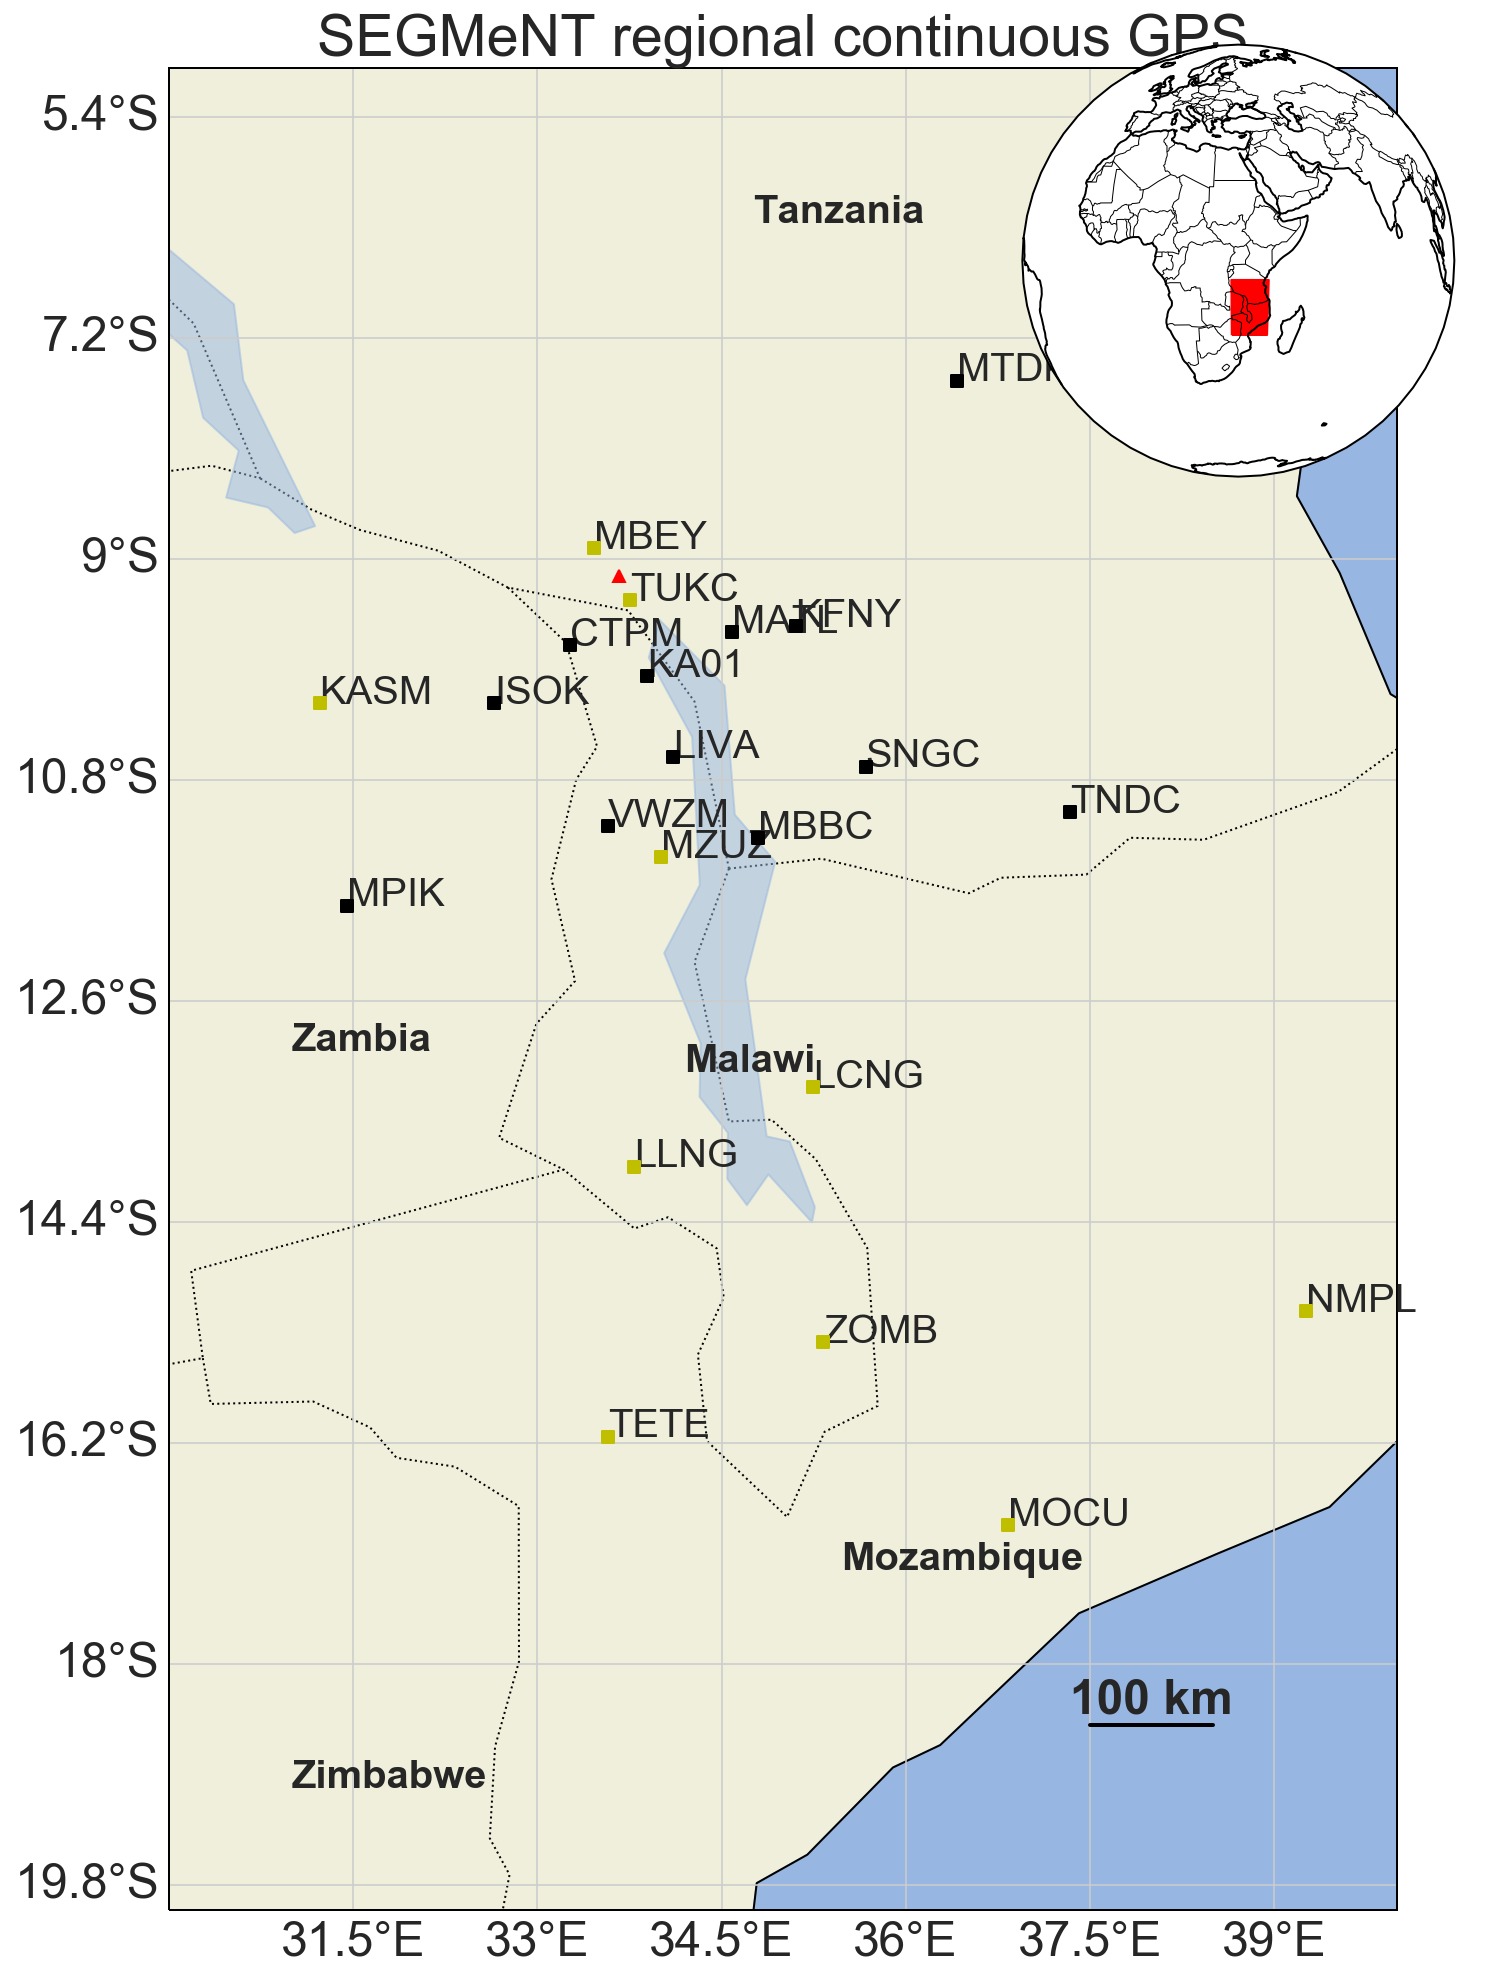

In [54]:
# Basic Map
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

fig = plt.figure(figsize=(11,17))
ax = plt.axes(projection=plot_CRS)
ax.set_extent([30, 40, -5, -20]) #W E N S 

textArgs = dict(fontsize=20)
add_points_to_map(ax, gfSeg, text='site', 
                  scatterArgs=dict(marker='s', color='k'),
                  textArgs = dict(fontsize=20)) 

add_points_to_map(ax, gfOther, text='site', 
                  scatterArgs=dict(marker='s', color='y'),
                  textArgs = dict(fontsize=20)) 

ax.plot(33.668, -9.135, 'r^', transform=geodetic_CRS, label='Rungwe Volcano')

#gf = gpd.read_file('/Users/scott/Downloads/ne_110m_populated_places/ne_110m_populated_places.shp')
#add_points_to_map(ax, gf)

gf = gpd.read_file('/Users/scott/Data/natural_earth/Natural_Earth_quick_start/110m_cultural/ne_110m_admin_0_countries.shp')
# These are polygons, so convert to central point
tmp = gf.copy()
tmp['geometry'] = gf.geometry.centroid
textArgs = dict(fontweight='bold', fontsize=20)
add_points_to_map(ax, tmp, text='name', point=False,
                  textArgs=textArgs)
# Some countries missing. Add them
ax.text(31.0, -13.0, 'Zambia', **textArgs)
ax.text(31.0, -19.0, 'Zimbabwe', **textArgs)


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add scale bar
ax.plot([37.5, 38.5], [-18.5, -18.5],'k-',lw=2, transform=geodetic_CRS)
ax.text(38.0, -18.4,'100 km', fontweight='bold', ha='center', transform=geodetic_CRS)

# Add inset map
insetproj = ccrs.Orthographic(central_longitude=32.0, central_latitude=0)
pos = [0.65, 0.65, 0.3, 0.3]
axin = plt.axes(pos, projection=insetproj)
boundary = polyFromCoords(ax.get_extent())
feature = cfeature.ShapelyFeature([boundary], geodetic_CRS)
axin.add_feature(feature, facecolor='r', color='r')
axin.coastlines('110m')
axin.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_title('SEGMeNT regional continuous GPS')

plt.savefig('segment_gps_map.pdf', bbox_inches='tight')

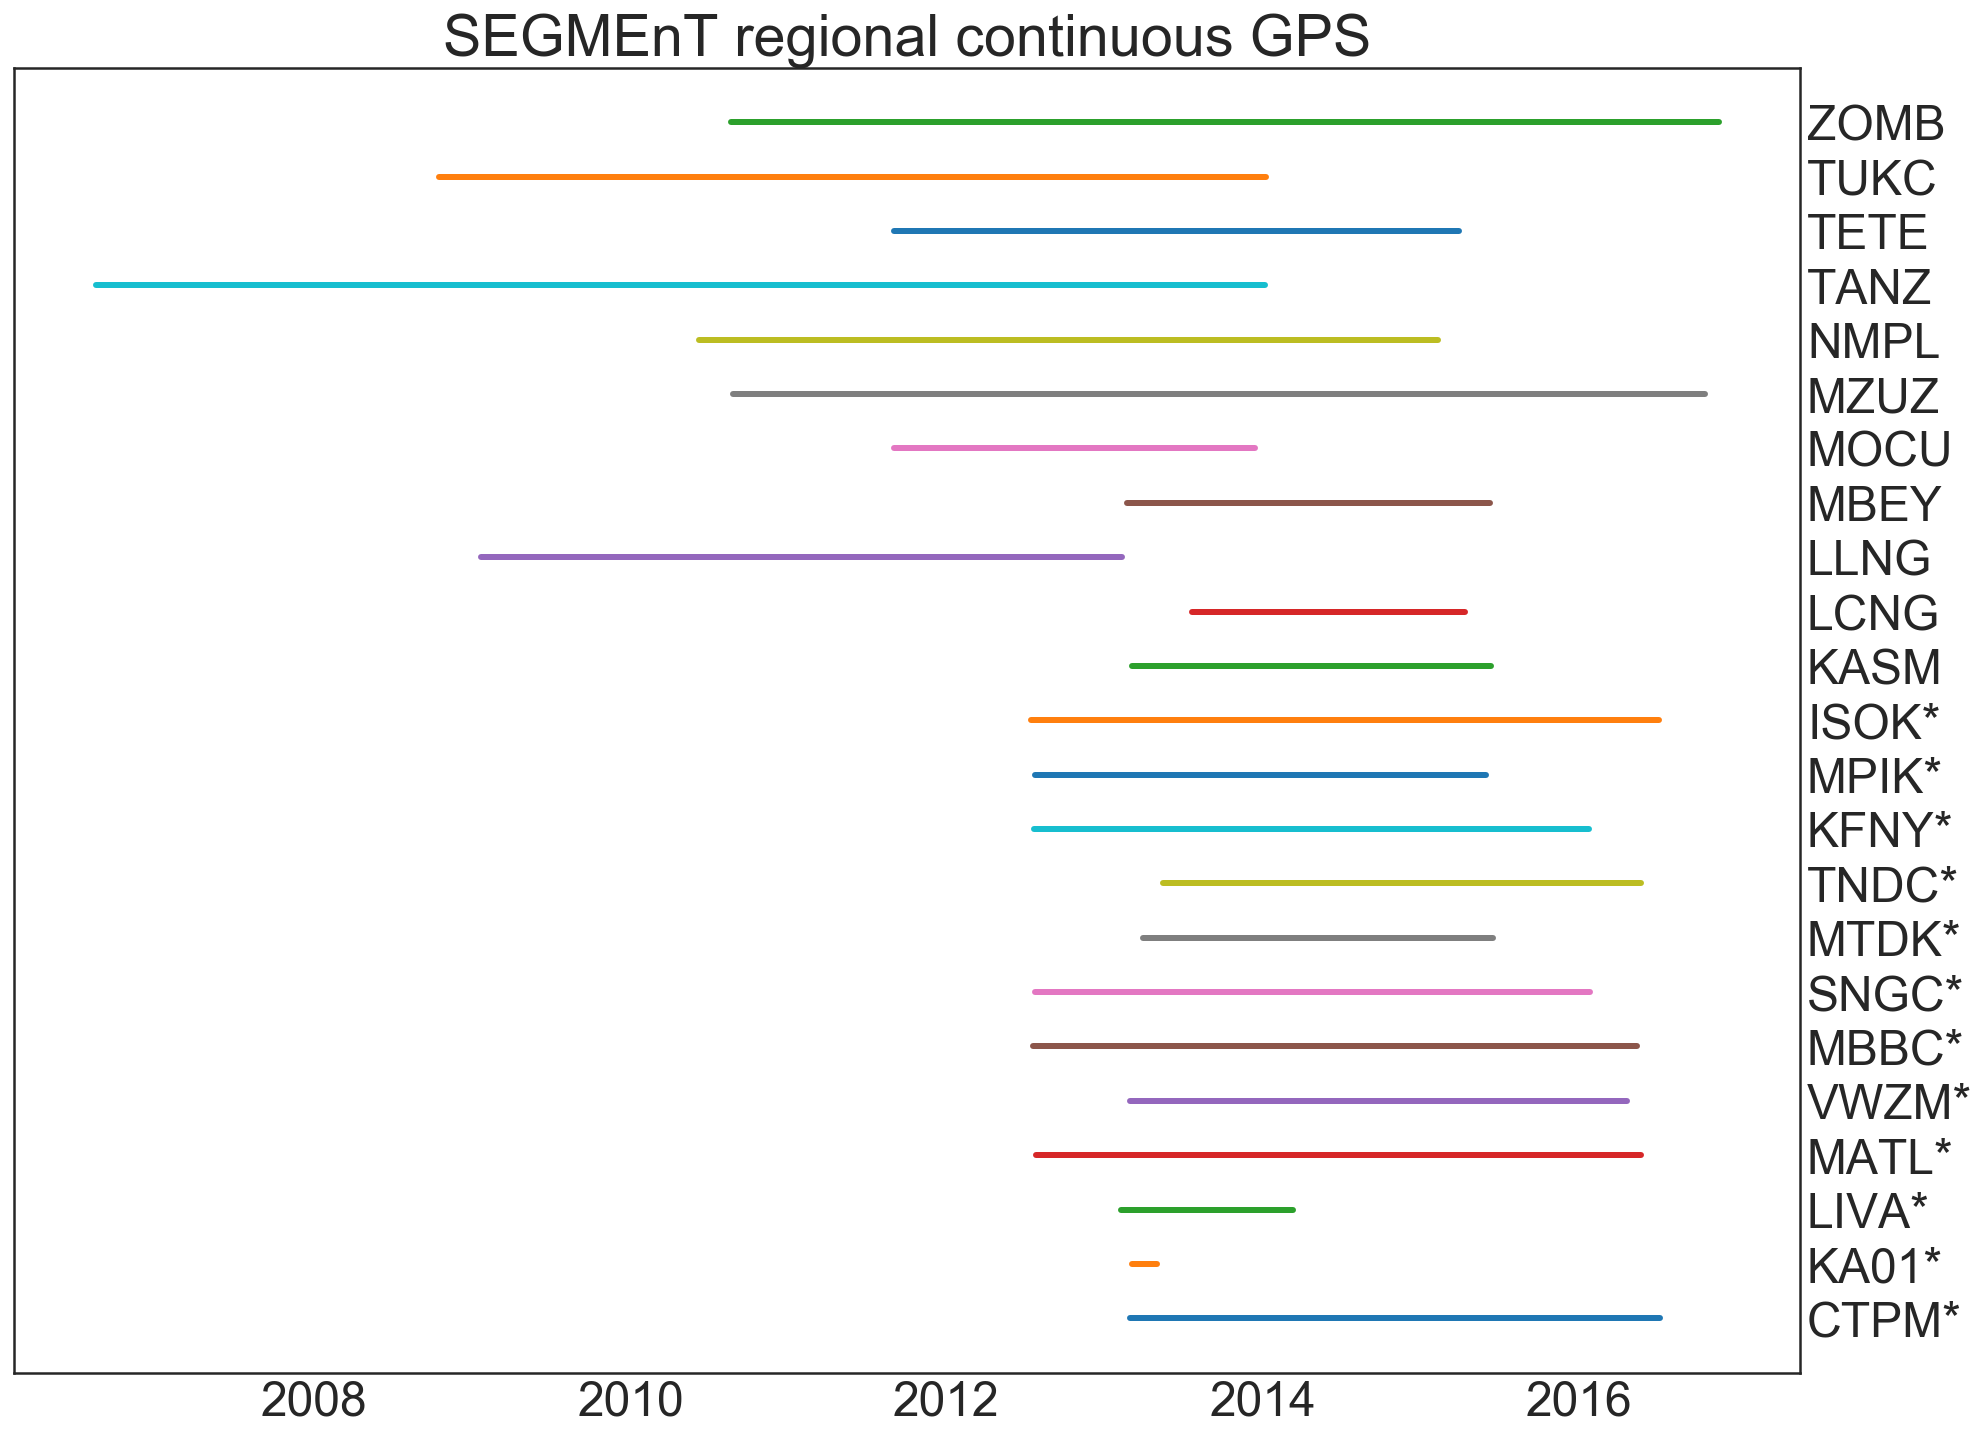

In [16]:
#NOTE: add datagaps to this plot (transparent line total range, solid lines where data actually exists!)

# Timeline of continuous GPS measurements on map
#eq = pd.to_datetime('2014-12-31')
df = pd.concat([dfSeg, dfOther], ignore_index=True)

fig,ax = plt.subplots(1,1,figsize=(16,12))

for i,row in df.iterrows():
    plt.plot([row.start, row.end], [i,i], lw=3)
plt.ylim(-1, len(df))
plt.title('SEGMEnT regional continuous GPS')
#plt.axvline(eq, linestyle='dashed', color='k', label='Mw 5.1')
plt.legend(loc='upper left')
# Add asterix to label of new SEGMEnT station
df.loc[df.site.isin(seg_sites), 'site'] = [x + '*' for x in seg_sites]
    
plt.yticks(df.index.values, df.site.values)
plt.tick_params(labelleft=False, labelright=True, bottom=True, top=True, right=True, left=True)

plt.savefig('segment_gps_timeline.pdf', bbox_inches='tight')

CTPM already dowloaded... skipping
ISOK already dowloaded... skipping
KA01 already dowloaded... skipping
KFNY already dowloaded... skipping
LIVA already dowloaded... skipping
MATL already dowloaded... skipping
MBBC already dowloaded... skipping
MPIK already dowloaded... skipping
MTDK already dowloaded... skipping
SNGC already dowloaded... skipping
TNDC already dowloaded... skipping
VWZM already dowloaded... skipping
KASM already dowloaded... skipping
LCNG already dowloaded... skipping
LLNG already dowloaded... skipping
MBEY already dowloaded... skipping
MOCU already dowloaded... skipping
MZUZ already dowloaded... skipping
NMPL already dowloaded... skipping
TANZ already dowloaded... skipping
TETE already dowloaded... skipping
TUKC already dowloaded... skipping
ZOMB already dowloaded... skipping


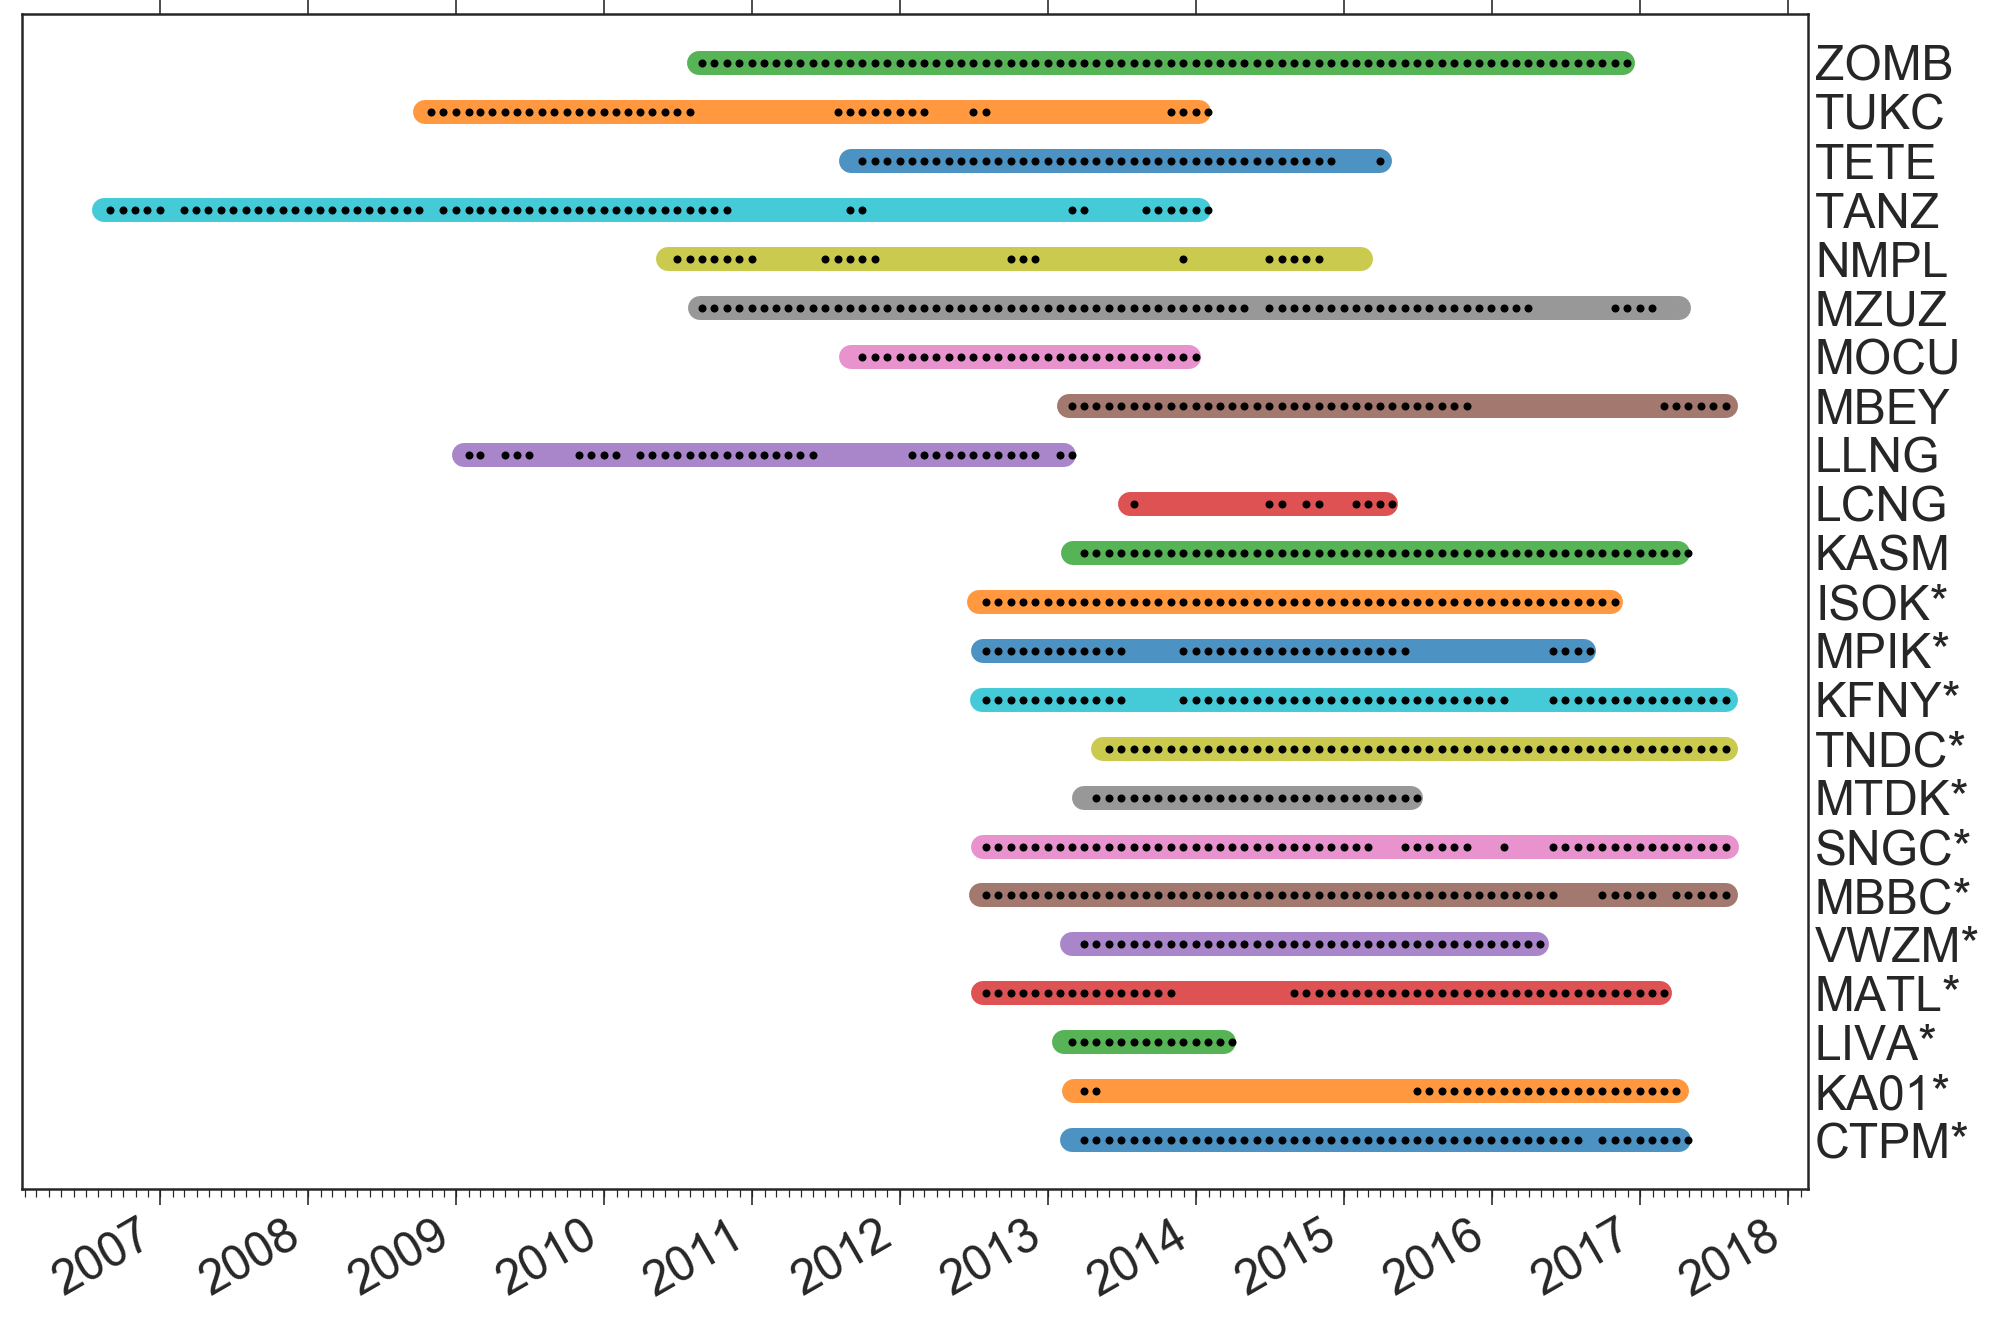

In [67]:
# Improved timeline w/ monthly data put in
df = pd.concat([dfSeg, dfOther], ignore_index=True)

fig,ax = plt.subplots(1,1,figsize=(16,12))

for i,row in df.iterrows():
    plt.plot([row.start, row.end], [i,i], lw=12, alpha=0.8)

    # Add a small dot for each month that has data
    tenv3 = gps.io.ungl.download_data(row.site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    months = tmp.up.resample('1M').count()
    validData = months[months>3]
    plt.plot(validData.index.values, i*np.ones(validData.index.values.size), 'k.')
    
    
plt.ylim(-1, len(df))
#plt.title('SEGMEnT regional continuous GPS')
#plt.axvline(eq, linestyle='dashed', color='k', label='Mw 5.1')
plt.legend(loc='upper left')
# Add asterix to label of new SEGMEnT station
df.loc[df.site.isin(seg_sites), 'site'] = [x + '*' for x in seg_sites]
    
plt.yticks(df.index.values, df.site.values)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.tick_params(axis='x', which='major', bottom=True, length=8)
plt.tick_params(labelleft=False, labelright=True, bottom=True, top=True, right=True, left=True)
fig.autofmt_xdate()

plt.savefig('segment_gps_timeline.pdf', bbox_inches='tight')

CTPM
CTPM already dowloaded... skipping
east Rate [mm/yr]=19.843918360283396
RMSE =  3.24756413641
KA01
KA01 already dowloaded... skipping
east Rate [mm/yr]=20.360379951537325
RMSE =  2.44738419252
LIVA
LIVA already dowloaded... skipping
east Rate [mm/yr]=21.2011647804544
RMSE =  2.68231824509
MATL
MATL already dowloaded... skipping
east Rate [mm/yr]=23.46413603136353
RMSE =  2.7052292294
VWZM
VWZM already dowloaded... skipping
east Rate [mm/yr]=16.433157071368004
RMSE =  4.58653205009
MBBC
MBBC already dowloaded... skipping
east Rate [mm/yr]=20.921923488412755
RMSE =  3.45941605401
SNGC
SNGC already dowloaded... skipping
east Rate [mm/yr]=19.391165781385133
RMSE =  3.53547673839
MTDK
MTDK already dowloaded... skipping
east Rate [mm/yr]=23.466705840339053
RMSE =  6.57215697907
TNDC
TNDC already dowloaded... skipping
east Rate [mm/yr]=22.392039819559773
RMSE =  2.31604882969
KFNY
KFNY already dowloaded... skipping
east Rate [mm/yr]=23.19300135079156
RMSE =  2.36630359155
MPIK
MPIK alrea

(734655.0, 736603.0)

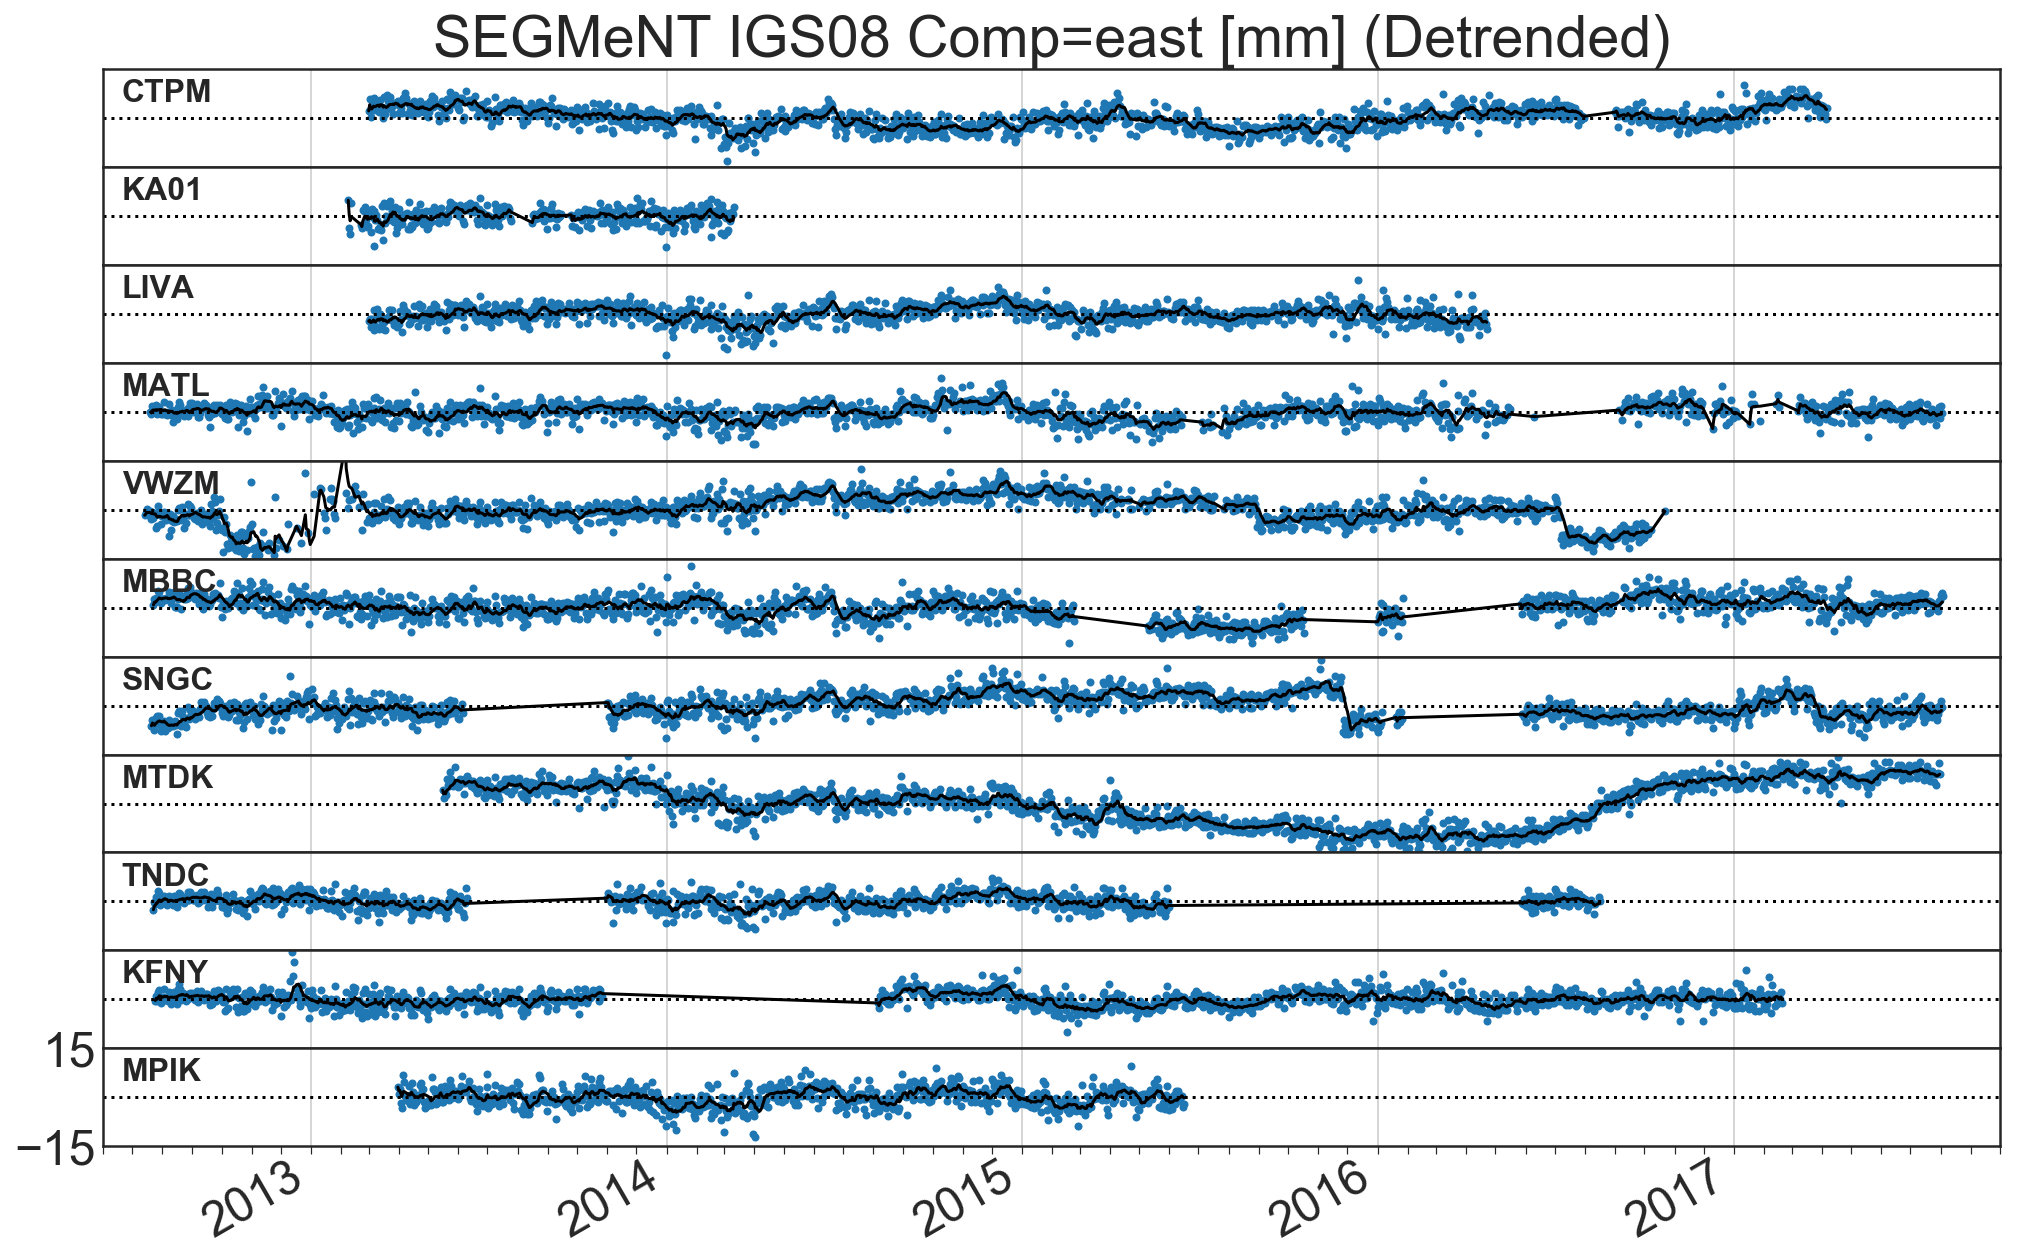

In [17]:
# Compare Vertical Components
# N-S profile of GPS stations that should show ETS event

sites = seg_sites
start = '2012/06/01'
end = '2017/10/01'
ymin = -15
ymax = 15

comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,11))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start=start, end=end)
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.axhline(color='k', linestyle=':')
    ax.tick_params(axis='y', labelleft=False)
    #ax.set_ylim(-10,10)
    # Highlight specific periods
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

ax.set_ylim(ymin,ymax)
yminmax = FixedLocator(ax.get_ylim())
ax.yaxis.set_major_locator(yminmax) #too much
ax.tick_params(axis='y', labelleft=True) #Label y-axis last line

axes[0].set_title('SEGMeNT IGS08 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)

plt.xlim(pd.to_datetime(start), pd.to_datetime(end))#specific time range



CTPM
CTPM already dowloaded... skipping
north Rate [mm/yr]=16.788991435009976
RMSE =  2.85479793605
KA01
KA01 already dowloaded... skipping
north Rate [mm/yr]=17.950002580910052
RMSE =  2.45712238569
LIVA
LIVA already dowloaded... skipping
north Rate [mm/yr]=17.77976779513051
RMSE =  2.86032144865
MATL
MATL already dowloaded... skipping
north Rate [mm/yr]=17.107171242062186
RMSE =  2.39213242642
VWZM
VWZM already dowloaded... skipping
north Rate [mm/yr]=16.868191680074
RMSE =  4.3757246624
MBBC
MBBC already dowloaded... skipping
north Rate [mm/yr]=15.986490859286949
RMSE =  2.677087667
SNGC
SNGC already dowloaded... skipping
north Rate [mm/yr]=18.88868856923364
RMSE =  3.83423668643
MTDK
MTDK already dowloaded... skipping
north Rate [mm/yr]=15.918553170821236
RMSE =  3.11348080794
TNDC
TNDC already dowloaded... skipping
north Rate [mm/yr]=16.878976455912287
RMSE =  2.31637255151
KFNY
KFNY already dowloaded... skipping
north Rate [mm/yr]=17.582600074154097
RMSE =  2.33129069055
MPIK
MPI

(734655.0, 736603.0)

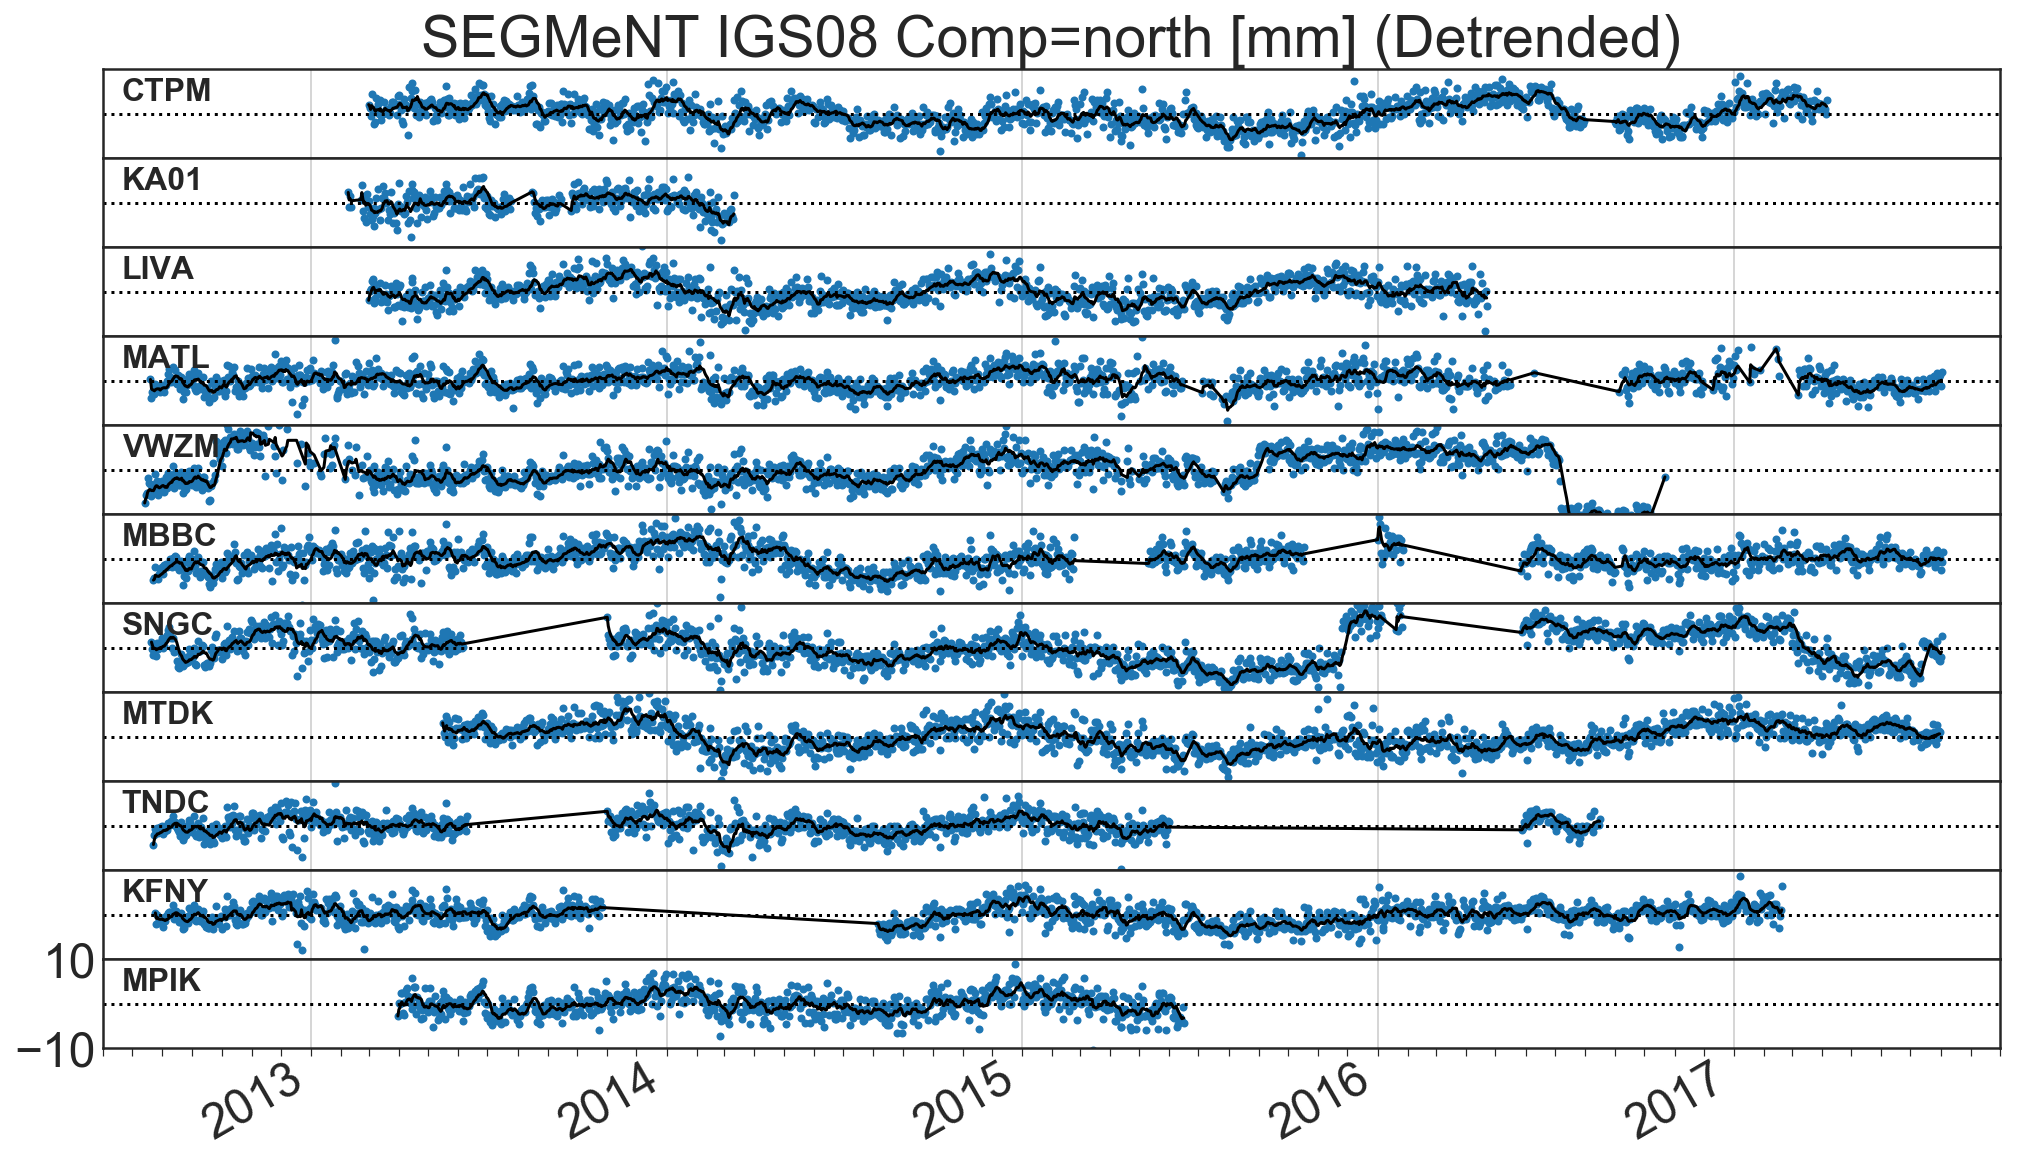

In [18]:
# Compare Vertical Components
# N-S profile of GPS stations that should show ETS event
sites = seg_sites
start = '2012/06/01'
end = '2017/10/01'
ymin = -10
ymax = 10

comp = 'north'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start=start, end=end)
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.axhline(color='k', linestyle=':')
    ax.tick_params(axis='y', labelleft=False)
    # Highlight specific periods
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) 
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

ax.set_ylim(ymin,ymax)
yminmax = FixedLocator(ax.get_ylim())
ax.yaxis.set_major_locator(yminmax) #too much
ax.tick_params(axis='y', labelleft=True) #Label y-axis last line

axes[0].set_title('SEGMeNT IGS08 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.xlim(pd.to_datetime(start), pd.to_datetime(end))#specific time range

CTPM
CTPM already dowloaded... skipping
up Rate [mm/yr]=5.380823689206396
RMSE =  8.17969360657
KA01
KA01 already dowloaded... skipping
up Rate [mm/yr]=3.7234419216515784
RMSE =  8.88238294693
LIVA
LIVA already dowloaded... skipping
up Rate [mm/yr]=2.34690430575281
RMSE =  9.18966215268
MATL
MATL already dowloaded... skipping
up Rate [mm/yr]=1.9611048682084786
RMSE =  17.7752517046
VWZM
VWZM already dowloaded... skipping
up Rate [mm/yr]=2.4285371455987104
RMSE =  9.34721637372
MBBC
MBBC already dowloaded... skipping
up Rate [mm/yr]=6.268080723324325
RMSE =  10.9158296287
SNGC
SNGC already dowloaded... skipping
up Rate [mm/yr]=1.9776481365643568
RMSE =  10.097858183
MTDK
MTDK already dowloaded... skipping
up Rate [mm/yr]=0.7332158431753051
RMSE =  9.58128894726
TNDC
TNDC already dowloaded... skipping
up Rate [mm/yr]=-0.24488445708552603
RMSE =  7.72286045535
KFNY
KFNY already dowloaded... skipping
up Rate [mm/yr]=2.6448466541443443
RMSE =  7.71117845086
MPIK
MPIK already dowloaded... sk

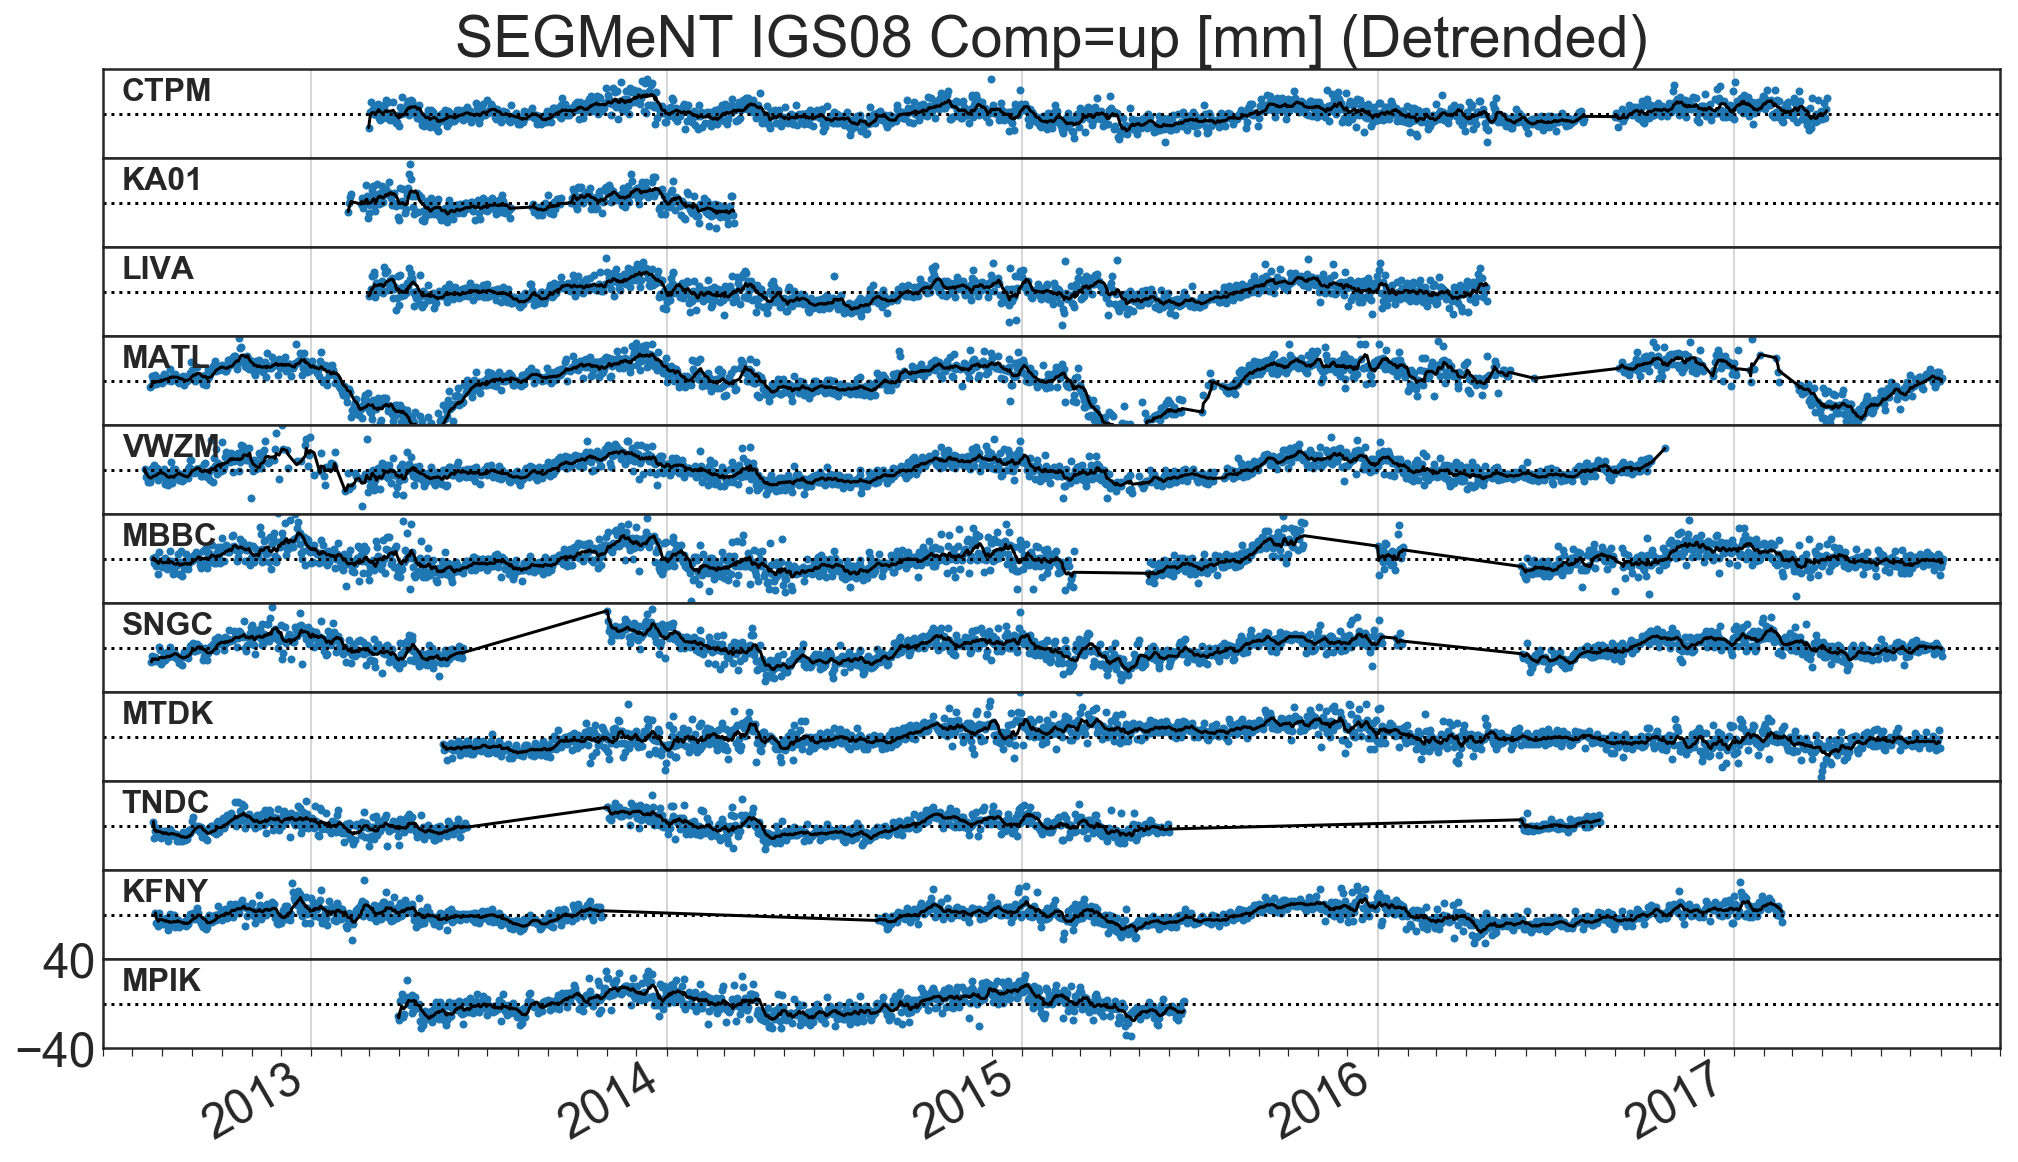

In [19]:
# Compare Vertical Components
# N-S profile of GPS stations that should show ETS event

sites = seg_sites
start = '2012/06/01'
end = '2017/10/01'
ymin = -40 #set to None for autoscaling
ymax = 40 

comp = 'up'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start=start, end=end)
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.axhline(color='k', linestyle=':')
    ax.tick_params(axis='y', labelleft=False)
    #ax.set_ylim(-10,10)
    # Highlight specific periods
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

ax.set_ylim(ymin,ymax)
yminmax = FixedLocator(ax.get_ylim())
ax.yaxis.set_major_locator(yminmax) #too much
ax.tick_params(axis='y', labelleft=True) #Label y-axis last line

axes[0].set_title('SEGMeNT IGS08 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)
#plt.yticks( (ymin,0,ymax), (str(ymin),'0',str(ymax)) )
#plt.tick_params(axis='y', which='major', left=True)#, length=4)

plt.xlim(pd.to_datetime(start), pd.to_datetime(end))#specific time range
#plt.ylim(-40,40)
print(ymin,ymax)

MATL already dowloaded... skipping


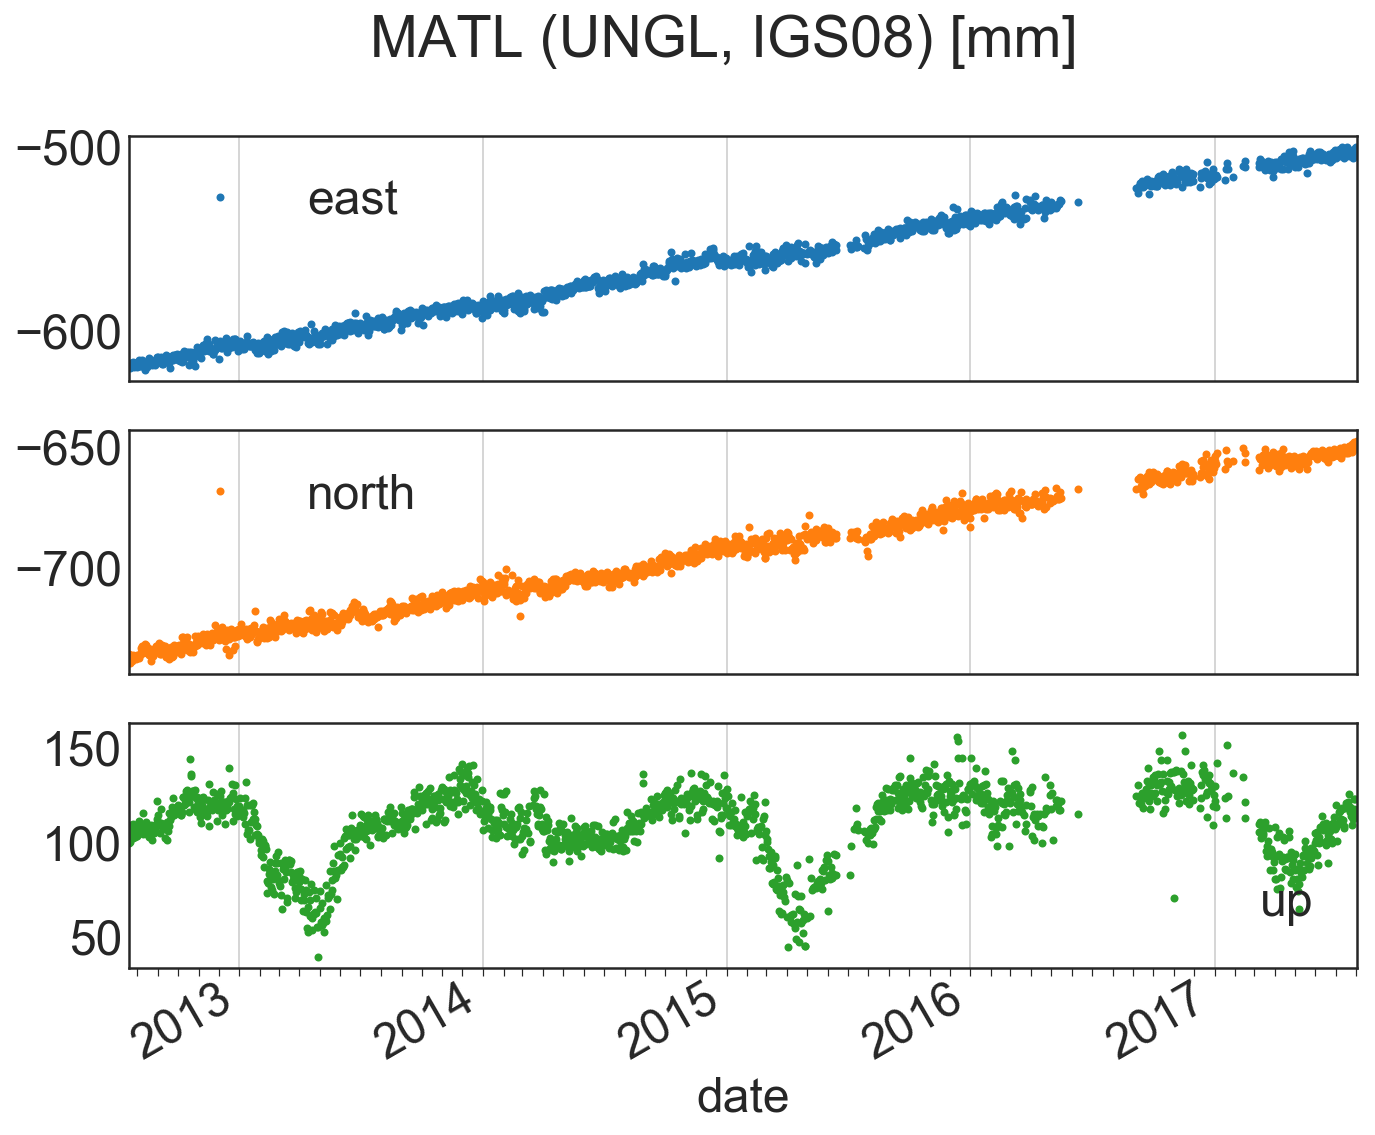

In [20]:
# Focus on raw 3 components from specific station.
# Load UNGL
station = 'MATL'
ref2= 'IGS08'
# Download data
tenv3 = gps.io.ungl.download_data(station, ref2, overwrite=False)
df2 = gps.io.ungl.load_tenv3(tenv3)
title2 = '{} (UNGL, {}) [mm]'.format(station, ref2)
axes = df2.plot(y=['east','north','up'], style='.' ,sharex=True, figsize=(11,8.5), subplots=True, title=title2)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
axes[-1].xaxis.set_major_locator(years)
axes[-1].xaxis.set_minor_locator(months) #too much
axes[-1].fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

plt.tick_params(axis='x', which='minor', bottom=True, length=4)
for ax in axes:
    ax.grid(axis='x')


Number of Stations =  24


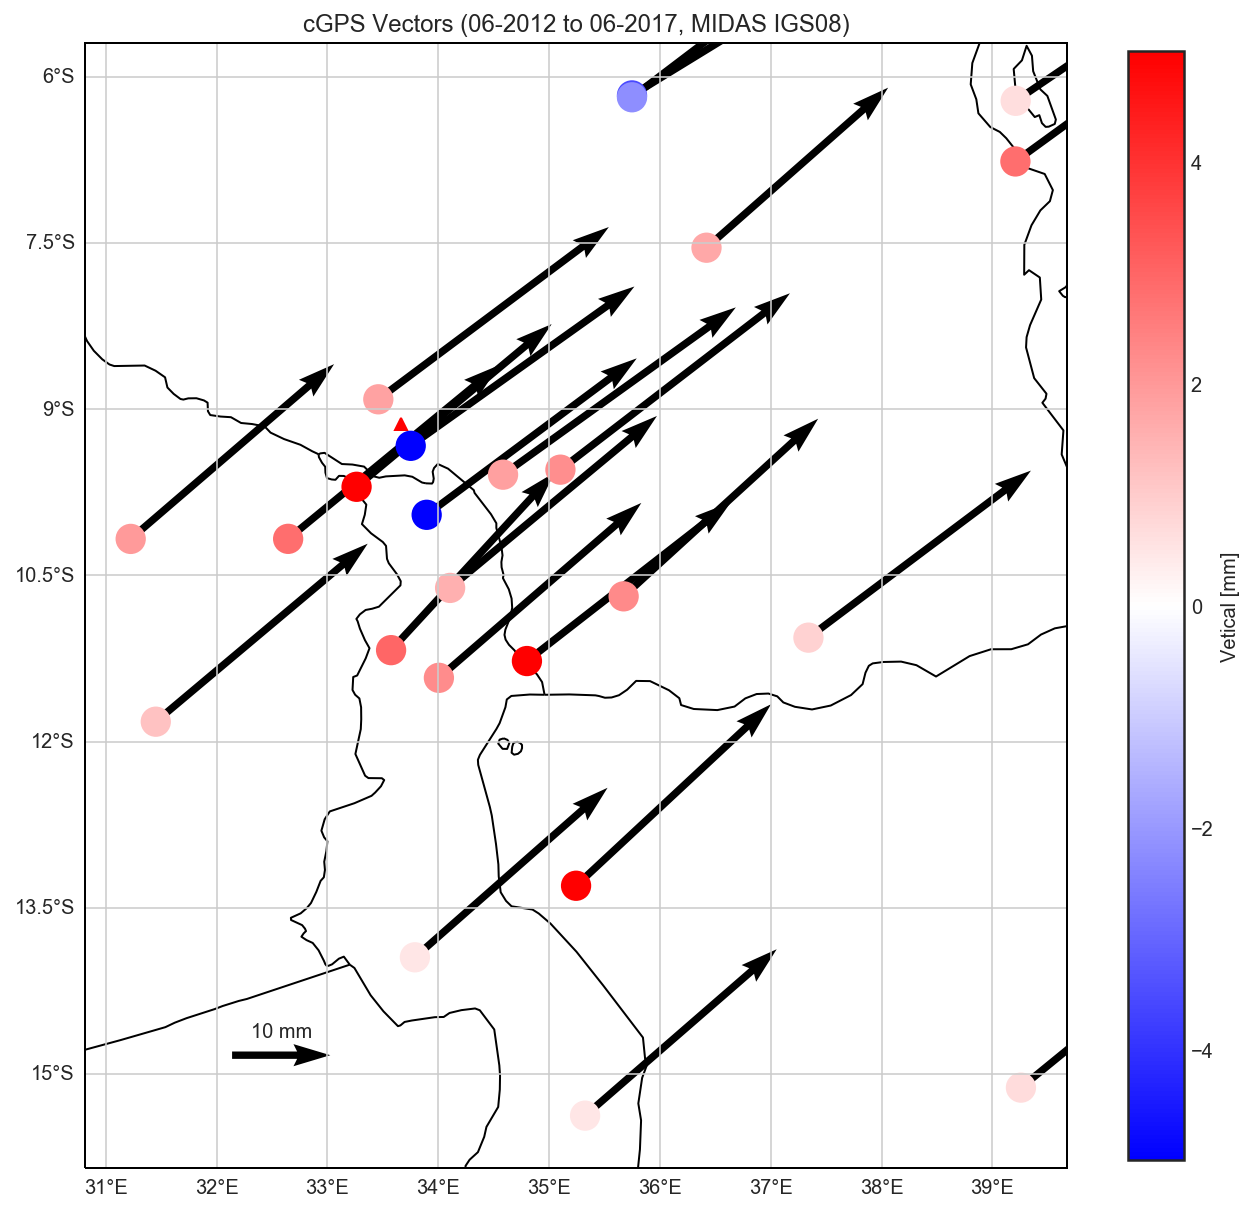

In [204]:
# Vector Map Plot
subset = dfS.query('(-16 < lat < -6) and (30 < lon < 40)') #Extend East to get subandes stations
df = pd.merge(dfM, subset, how='inner', on=['site'])

print('Number of Stations = ', df.shape[0])
fig, ax = plt.subplots(1,1,figsize=(11,17))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = plt.scatter(df.lon, df.lat, c=df.up, s=200, 
                 norm=None,
                 vmin=-5,
                 vmax=5,
                 cmap=plt.cm.bwr, #linear scale 
                 #cmap=plt.cm.bwr, #symmetric scale
                 transform=ccrs.Geodetic(),
                 zorder=2,
                 )



# Could plot far-field subset or scale vectors close to EQ by 1/2...
Q = plt.quiver(df.lon, df.lat, df.east, df.north, scale=100, color='k', zorder=1) # bigger arrows
qk = plt.quiverkey(Q, 0.2, 0.1, 10, '10 mm', 
                   labelpos='N',
                   coordinates='axes')

ax.coastlines('50m')
borders = cfeature.BORDERS
borders.scale='50m'
ax.add_feature(borders)
ax.plot(33.668, -9.135, 'r^', transform=geodetic_CRS, label='Rungwe Volcano')

cb = plt.colorbar(sc, orientation='vertical', shrink=0.6)
cb.set_label('Vetical [mm]')

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('cGPS Vectors (06-2012 to 06-2017, MIDAS IGS08)')

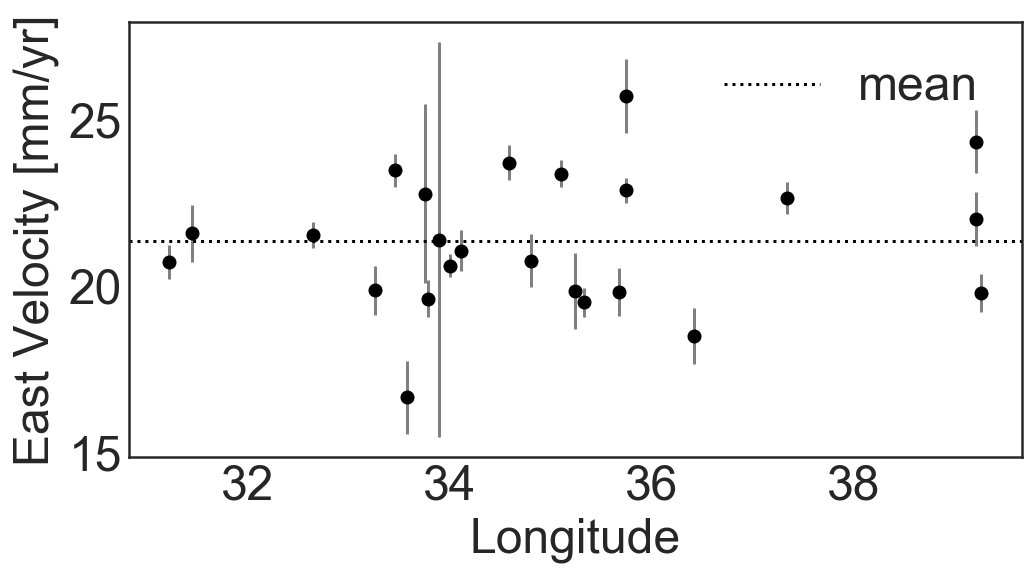

In [65]:
# Plot Velocity as function of longitude
plt.figure(figsize=(8,4))
plt.errorbar(df.lon.values, df.east.values, df.err_e.values, fmt='ko', ecolor='gray')
plt.axhline(df.east.mean(),color='k', linestyle=':', label='mean')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('East Velocity [mm/yr]')

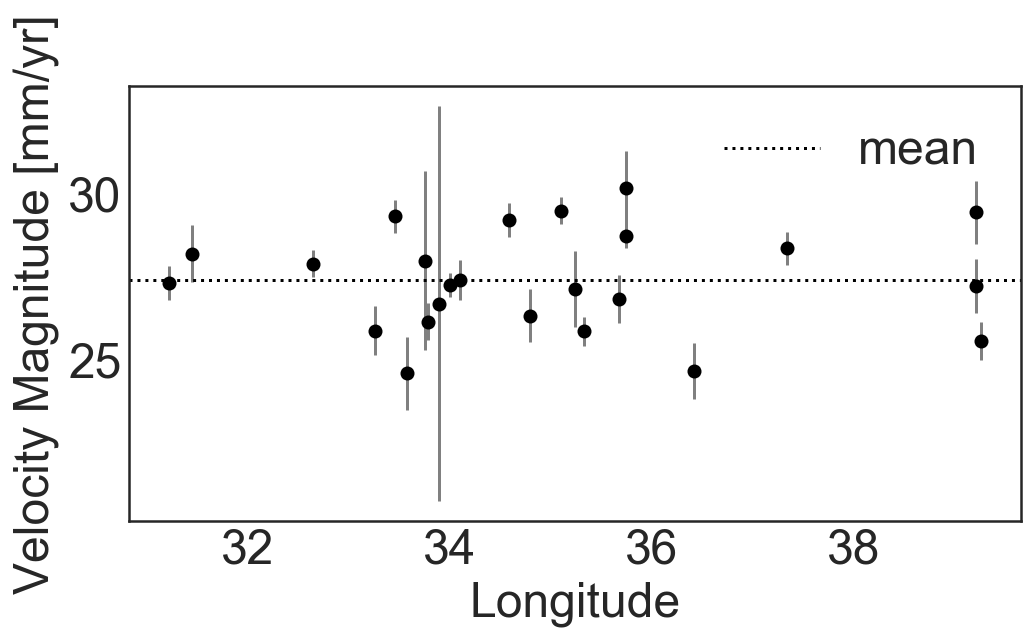

In [66]:
df['magnitude'] = np.hypot(df.east, df.north)

plt.figure(figsize=(8,4))
plt.errorbar(df.lon.values, df.magnitude.values, df.err_e.values, fmt='ko', ecolor='gray')
plt.axhline(df.magnitude.mean(),color='k', linestyle=':', label='mean')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Velocity Magnitude [mm/yr]')

Number of Stations =  24


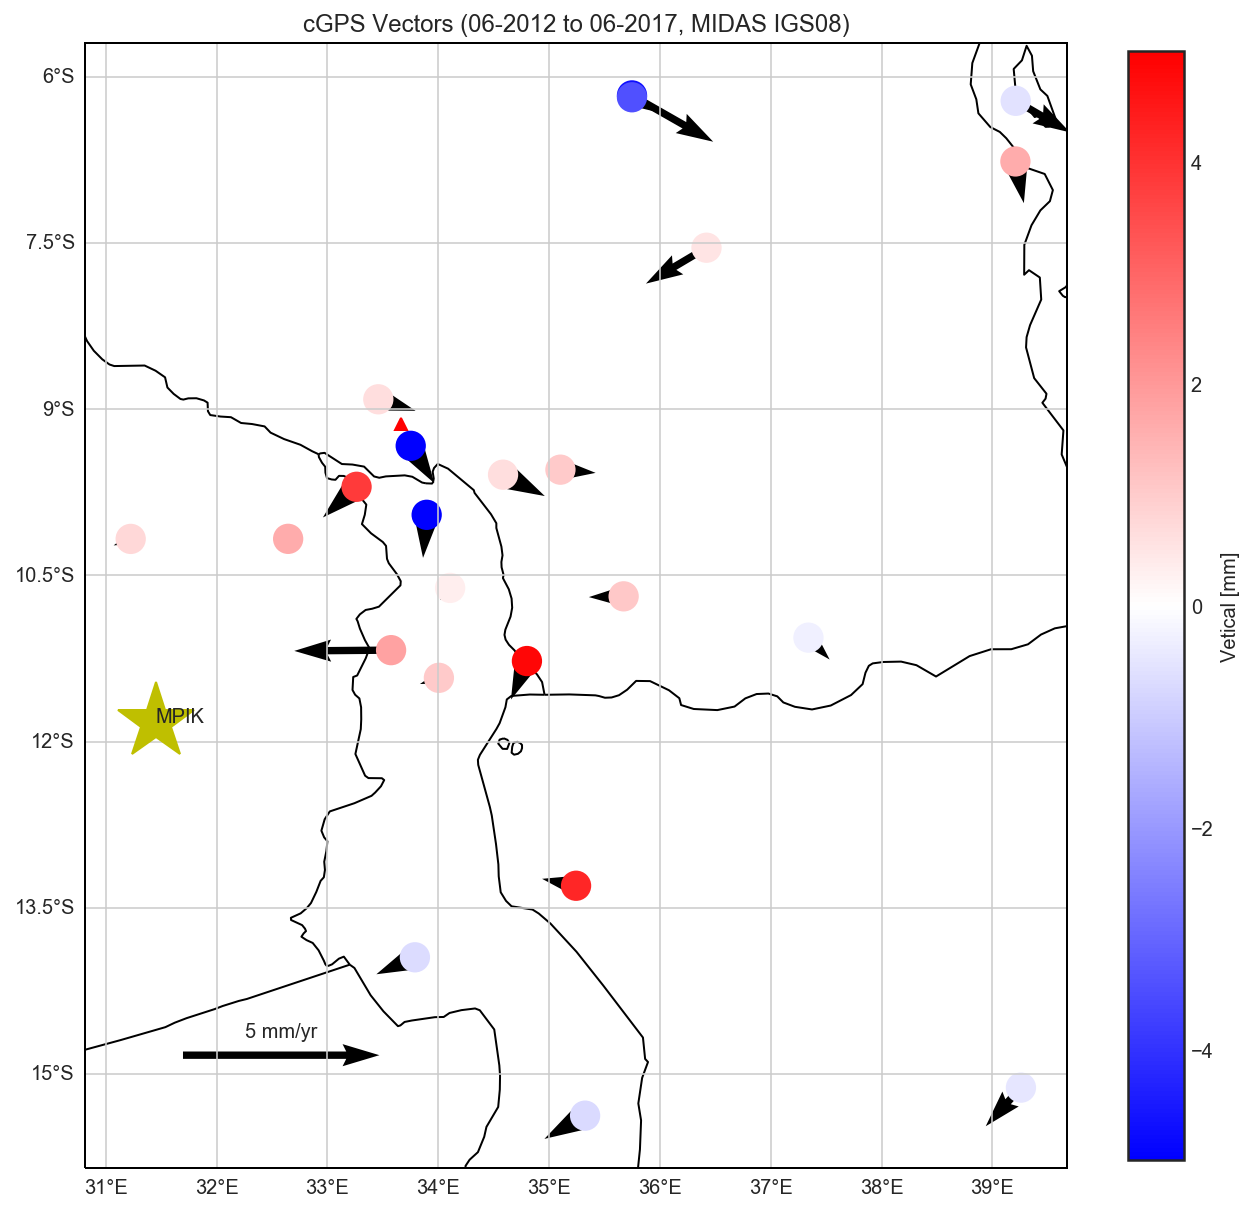

In [221]:
# Pick a reference station and plot velocities relative velocities
# Vector Map Plot
subset = dfS.query('(-16 < lat < -6) and (30 < lon < 40)') #Extend East to get subandes stations
df = pd.merge(dfM, subset, how='inner', on=['site'])

#Plot velocities relative to KA01, label stations
ref = df.query('site == "MPIK"')

print('Number of Stations = ', df.shape[0])
fig, ax = plt.subplots(1,1,figsize=(11,17))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = plt.scatter(df.lon, df.lat, c=df.up-ref.up.values, s=200, 
                 norm=None,
                 vmin=-5,
                 vmax=5,
                 cmap=plt.cm.bwr, #linear scale 
                 #cmap=plt.cm.bwr, #symmetric scale
                 transform=ccrs.Geodetic(),
                 zorder=2,
                 )



# Could plot far-field subset or scale vectors close to EQ by 1/2...
Q = plt.quiver(df.lon, df.lat, df.east-ref.east.values, df.north-ref.north.values, scale=50, color='k', zorder=1) # bigger arrows
qk = plt.quiverkey(Q, 0.2, 0.1, 10, '5 mm/yr', 
                   labelpos='N',
                   coordinates='axes')

ax.coastlines('50m')
borders = cfeature.BORDERS
borders.scale='50m'
ax.add_feature(borders)
ax.plot(33.668, -9.135, 'r^', transform=geodetic_CRS, label='Rungwe Volcano')

ax.plot(ref.lon, ref.lat, 'y*', ms=40, transform=geodetic_CRS, label='Reference')
ax.text(ref.lon, ref.lat, ref.site.values[0], transform=geodetic_CRS)

cb = plt.colorbar(sc, orientation='vertical', shrink=0.6)
cb.set_label('Vetical [mm]')

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('cGPS Vectors (06-2012 to 06-2017, MIDAS IGS08)')

MATL already dowloaded... skipping
East: 23.70 +/- 0.52 mm/yr
North: 17.04 +/- 0.42 mm/yr
Up: 1.84 +/- 1.96 mm/yr


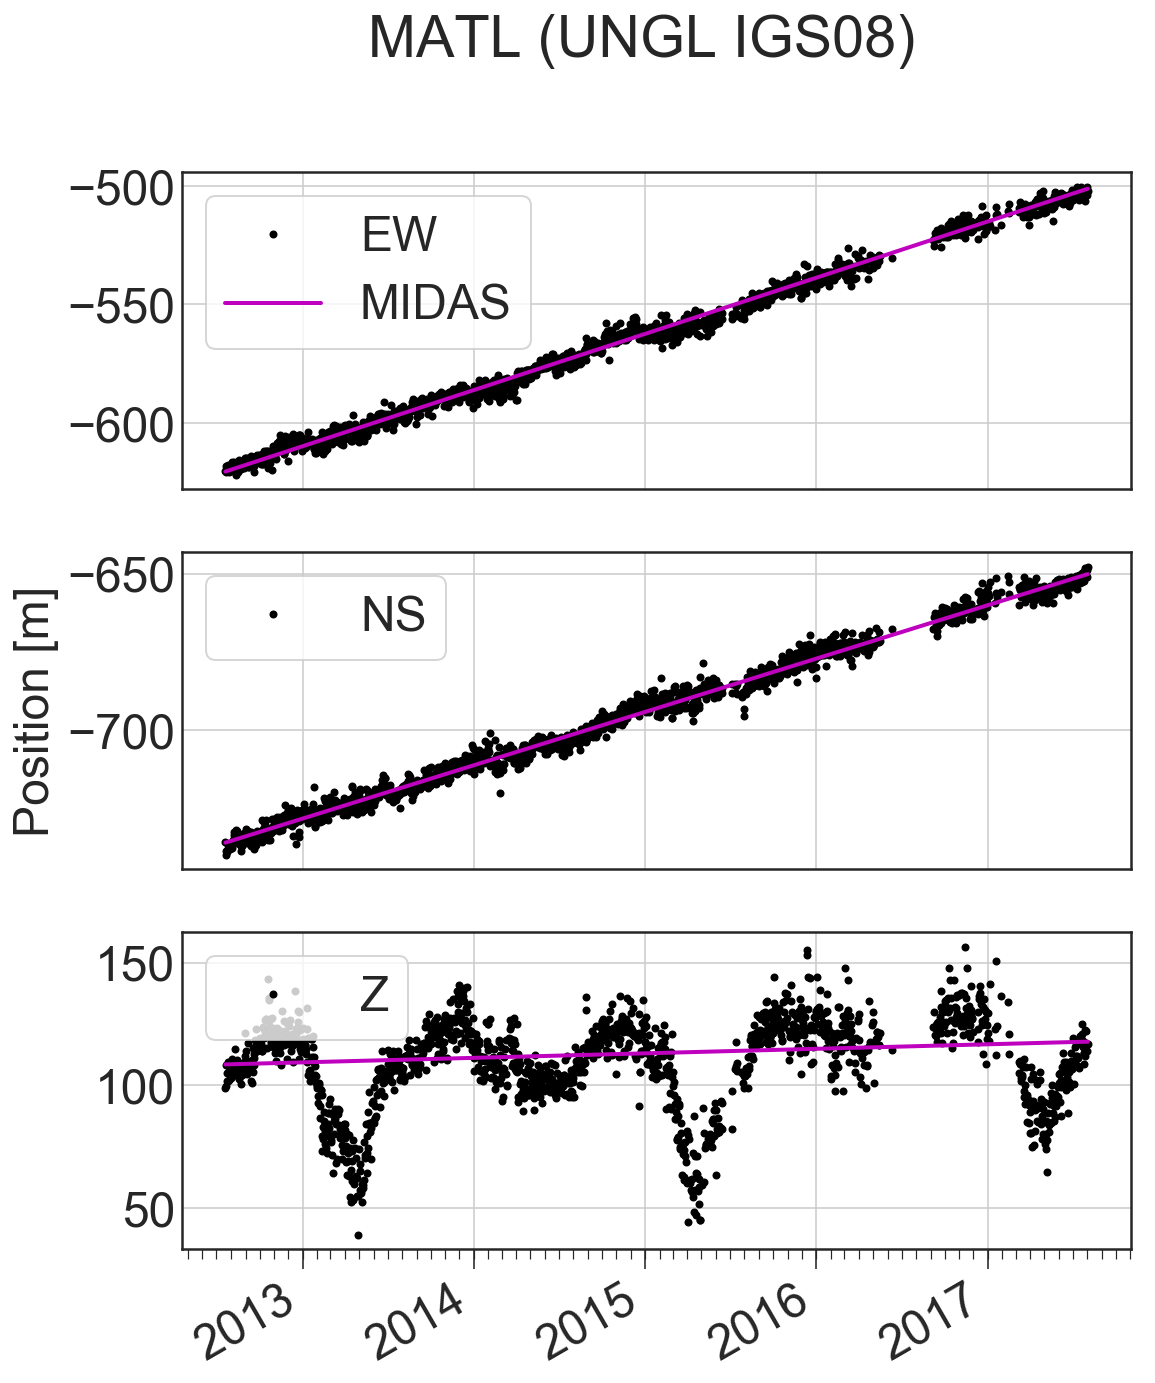

In [22]:
# Focus on raw 3 components from specific station.
# Load UNGL
station = 'MATL'
ref2= 'IGS08'
# Download data
tenv3 = gps.io.ungl.download_data(station, ref2, overwrite=False)
df2 = gps.io.ungl.load_tenv3(tenv3)

dfM2 = gps.io.ungl.load_midas(station)
df2 = gps.io.ungl.add_midas(df2, dfM2)
gps.plot.all(df2, dfMidas=df2)

# Print MIDAS rates
print('East: {:.2f} +/- {:.2f} mm/yr'.format(dfM2.east.values[0], dfM2.err_e.values[0]))
print('North: {:.2f} +/- {:.2f} mm/yr'.format(dfM2.north.values[0], dfM2.err_n.values[0]))
print('Up: {:.2f} +/- {:.2f} mm/yr'.format(dfM2.up.values[0], dfM2.err_u.values[0]))

plt.suptitle(station + ' (UNGL IGS08)')

In [23]:
# Animate sliding window in GPS time series
def initialize(site='MATL', daySpan=30, spanStart='2012/7/20', spanEnd='2012/07/30', ymin=None, ymax=None):
    '''
    Show 'moving' moving average window
    '''
    
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    
    tmp = tmp.dropna()
    window = '{}d'.format(daySpan)
    tmp = gps.analysis.do_detrend(tmp, comp, start=0, end=-1)
    roll = tmp['detrend1_'+comp].rolling(window).mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-', label='{} mean'.format(daySpan))
    ax.scatter(tmp.index, tmp['detrend1_'+comp].values, marker='.')
    ax.legend(loc='upper right', prop=dict(weight='normal'))
    ax.grid(axis='x')
    ax.axhline(color='k', linestyle=':')
    ax.tick_params(axis='y', labelleft=False)

    # Highlight specific periods
    span = ax.axvspan(pd.to_datetime(spanStart), pd.to_datetime(spanEnd), color='gray', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

    months = pltdate.MonthLocator()
    years = pltdate.YearLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(months) #too much
    ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

    ax.set_ylim(ymin,ymax)
    yminmax = FixedLocator(ax.get_ylim())
    ax.yaxis.set_major_locator(yminmax) #too much
    ax.tick_params(axis='y', labelleft=True) #Label y-axis last line

    ax.set_title('SEGMeNT IGS08 Comp={} [mm] (Detrended)'.format(comp))
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.autofmt_xdate()

    plt.tick_params(axis='x', which='minor', bottom=True, length=4)
    #plt.yticks( (ymin,0,ymax), (str(ymin),'0',str(ymax)) )
    #plt.tick_params(axis='y', which='major', left=True)#, length=4)

    #plt.xlim(pd.to_datetime(start), pd.to_datetime(end))#specific time range
    #plt.ylim(-40,40)
    #print(ymin,ymax)
    return span

In [24]:
def update_vspan(i,span):
    ''' 
    Assume x units are in days
    '''
    
    oldcoords = span.get_xy()
    start = oldcoords[0,0]
    end = oldcoords[3,0]
    daySpan = end-start
    #dt.datetime.fromordinal(int(start)) back to datetime object
    newcoords = oldcoords.copy()
    newcoords[oldcoords == start] = end
    newcoords[oldcoords == end] = end+daySpan
    
    span.set_xy(newcoords)
    return span

In [25]:
from matplotlib import animation

MATL already dowloaded... skipping
up Rate [mm/yr]=1.959176663722125
RMSE =  17.7808802548


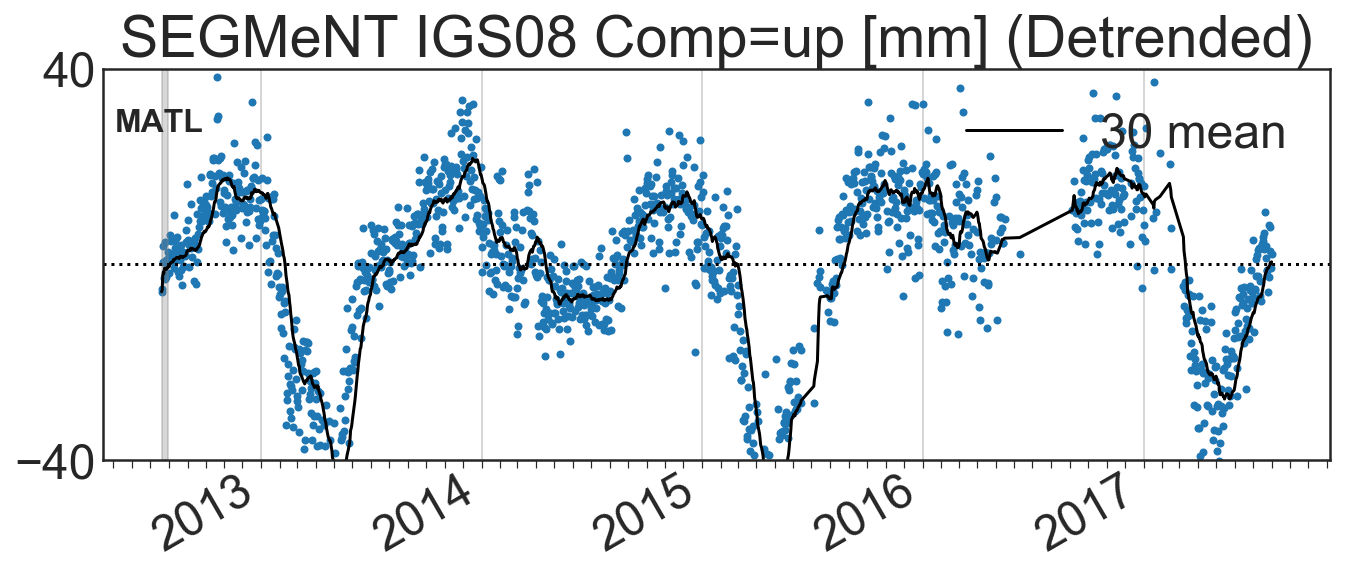

In [42]:
# call the animator. blit=True means only re-draw the parts that have changed.
site='MATL'
daySpan=30
spanStart='2012/7/20'
spanEnd='2012/07/30'
ymin=-40
ymax=40

fig,ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(11,4))
tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
tmp = gps.io.ungl.load_tenv3(tenv3)

tmp = tmp.dropna()
window = '{}d'.format(int(daySpan))
tmp = gps.analysis.do_detrend(tmp, comp, start=0, end=-1)
roll = tmp['detrend1_'+comp].rolling(window).mean() #10day rolling mean
ax.plot(roll.index, roll.values, 'k-', label='{} mean'.format(daySpan))
ax.scatter(tmp.index, tmp['detrend1_'+comp].values, marker='.')
ax.legend(loc='upper right', prop=dict(weight='normal'))
ax.grid(axis='x')
ax.axhline(color='k', linestyle=':')
ax.tick_params(axis='y', labelleft=False)

# Highlight specific periods
span = ax.axvspan(pd.to_datetime(spanStart), pd.to_datetime(spanEnd), color='gray', alpha=0.3)
ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

ax.set_ylim(ymin,ymax)
yminmax = FixedLocator(ax.get_ylim())
ax.yaxis.set_major_locator(yminmax) #too much
ax.tick_params(axis='y', labelleft=True) #Label y-axis last line

ax.set_title('SEGMeNT IGS08 Comp={} [mm] (Detrended)'.format(comp))
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)

In [27]:
anim = animation.FuncAnimation(fig, update_vspan, fargs=[span], frames=50, blit=False)
plt.rc('animation', html='html5')

In [28]:
#anim #uncomment to show animation in browser

In [29]:
# Gray Bar not appearing?!
anim.save('vspan_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# Classify seasonal signal, compare to GRACE 

In [30]:
path = './GRACE/colorado_timseries.txt'
dfG = pd.read_csv(path, skiprows=7, sep=r"\s*", names=['time','grace','grace_scaled','err','err_scaled'])

In [31]:
dfG.head()

time   grace  grace_scaled    err  err_scaled
0  2002.29  261.44        292.32  29.07       26.63
1  2002.36  269.69        301.54  29.07       26.63
2  2002.62  -34.96        -39.08  29.07       26.63
3  2002.71  -62.44        -69.82  29.07       26.63
4  2002.79  -98.79       -110.45  29.07       26.63

In [32]:
def decyear2datetime(decyear):
    year = int(decyear)
    decimal = decyear - year
    base = pd.datetime(year,1,1)
    secondsInYear = pd.datetools.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds()) #accounts for leap years
    return base + secondsInYear*decimal

In [33]:
dfG['datetime'] = dfG.time.apply(decyear2datetime)
dfG = dfG.set_index('datetime')
dfG['date'] = dfG.index

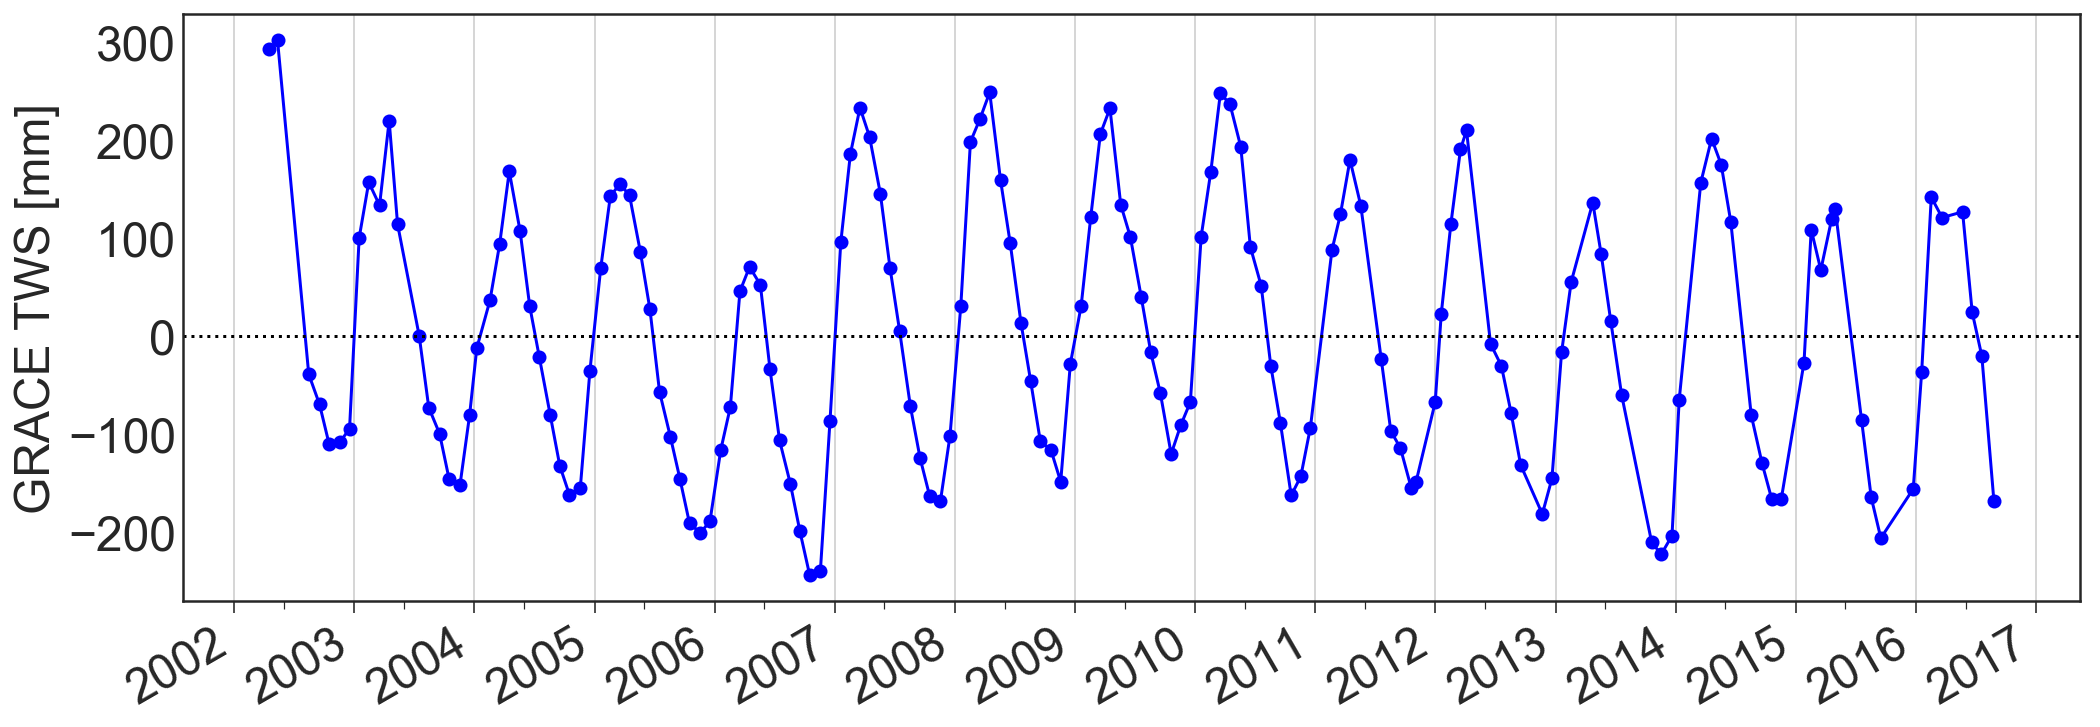

In [34]:
fig, ax = plt.subplots(1,1,figsize=(17,6))
plt.plot(dfG.index, dfG.grace_scaled, 'bo-')
months = pltdate.MonthLocator(6)
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.tick_params(axis='x', which='major', bottom=True, length=6)
plt.axhline(0,linestyle=':', color='k')
plt.grid(True, axis='x')
plt.ylabel('GRACE TWS [mm]')

In [35]:
gps.analysis.get_extrema(dfG, 'grace_scaled')

Minima:  ['2002-10-16T08:23:59.999999000' '2003-03-18T15:36:00.000001000'
 '2003-11-18T04:48:00.000003000' '2004-10-16T03:21:35.999999000'
 '2005-11-18T04:48:00.000003000' '2006-10-16T08:23:59.999999000'
 '2007-11-18T04:48:00.000003000' '2008-11-18T01:55:12.000003000'
 '2009-10-19T23:59:59.999999000' '2010-10-19T23:59:59.999999000'
 '2011-10-19T23:59:59.999999000' '2012-11-21T17:45:36.000003000'
 '2013-11-18T04:48:00.000003000' '2014-11-18T04:48:00.000003000'
 '2015-03-18T15:36:00.000001000' '2015-09-17T03:36:00.000001000'
 '2016-03-21T12:28:48.000001000']
Maxima:  ['2002-05-12T09:35:59.999997000' '2003-02-13T19:11:59.999997000'
 '2003-04-16T20:23:59.999999000' '2004-04-16T03:21:35.999999000'
 '2005-03-18T15:36:00.000001000' '2006-04-16T20:23:59.999999000'
 '2007-03-18T15:36:00.000001000' '2008-04-16T03:21:35.999999000'
 '2009-04-16T20:23:59.999999000' '2010-03-18T15:36:00.000001000'
 '2011-04-16T20:23:59.999999000' '2012-04-05T03:50:24.000000000'
 '2013-04-24T03:35:59.999998000' '2014

(array([  4,   9,  16,  27,  40,  51,  64,  76,  87,  99, 109, 120, 129,
        139, 142, 147, 151]),
 array([  1,   8,  10,  21,  32,  45,  56,  69,  81,  92, 104, 115, 124,
        133, 141, 144, 150, 152]))

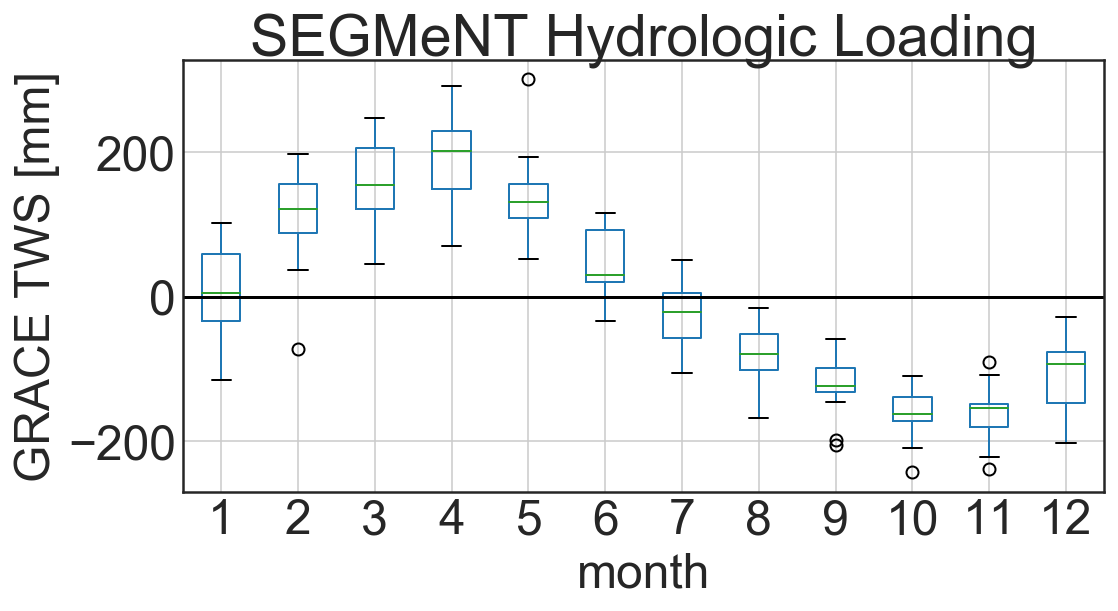

In [36]:
dfG['month'] = dfG.index.month
ax = dfG.boxplot(column=['grace_scaled'], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('SEGMeNT Hydrologic Loading')
plt.ylabel('GRACE TWS [mm]')

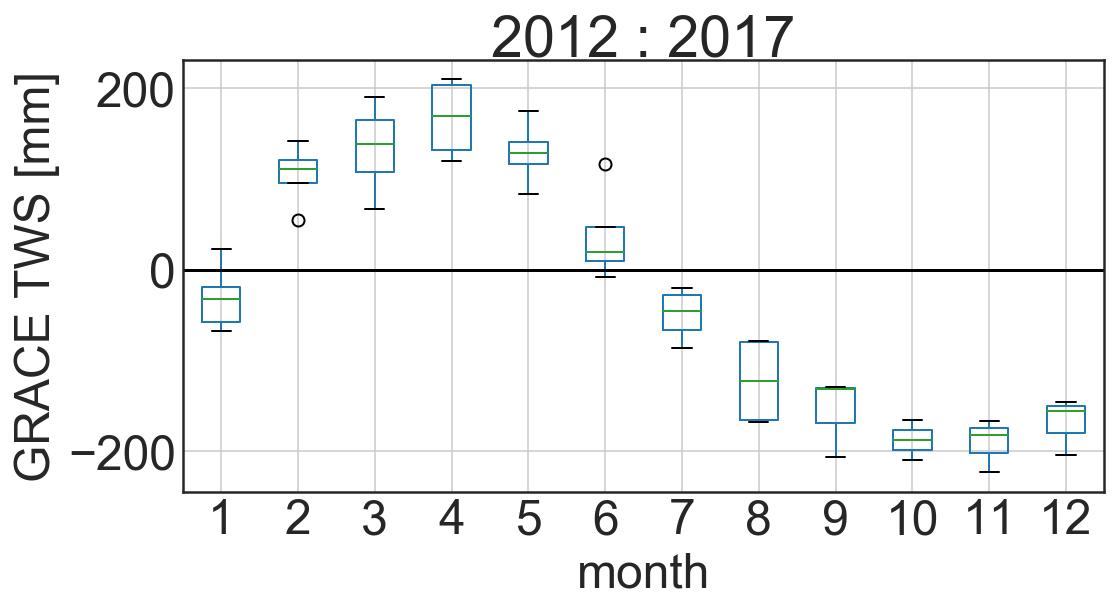

In [37]:
# Compare to boxplot of MATL GPS (ideally same time period)
crop = dfG['2012-01-01':'2017-01-01']
ax = crop.boxplot(column=['grace_scaled'], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('2012 : 2017')
plt.ylabel('GRACE TWS [mm]')

up Rate [mm/yr]=1.9573220625006564
RMSE =  17.7865216118


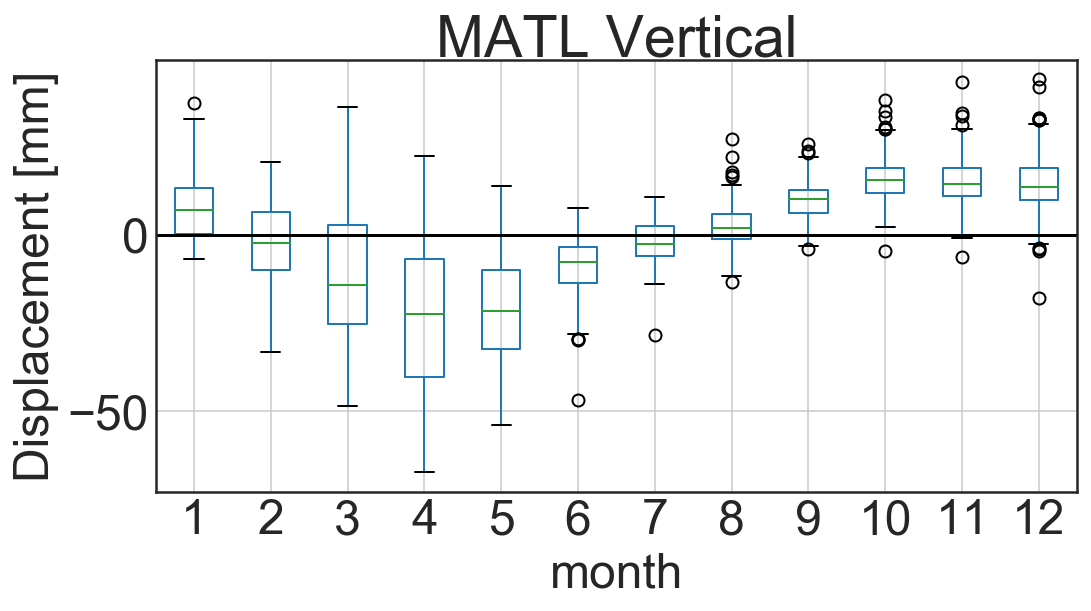

In [38]:
comp = 'up'
tmp['month'] = tmp.index.month
tmp = gps.analysis.do_detrend(tmp, comp, start=0, end=-1)
ax = tmp.boxplot(column=['detrend1_'+comp], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('MATL Vertical')
plt.ylabel('Displacement [mm]')

north Rate [mm/yr]=17.10543157947063
RMSE =  2.3935417476


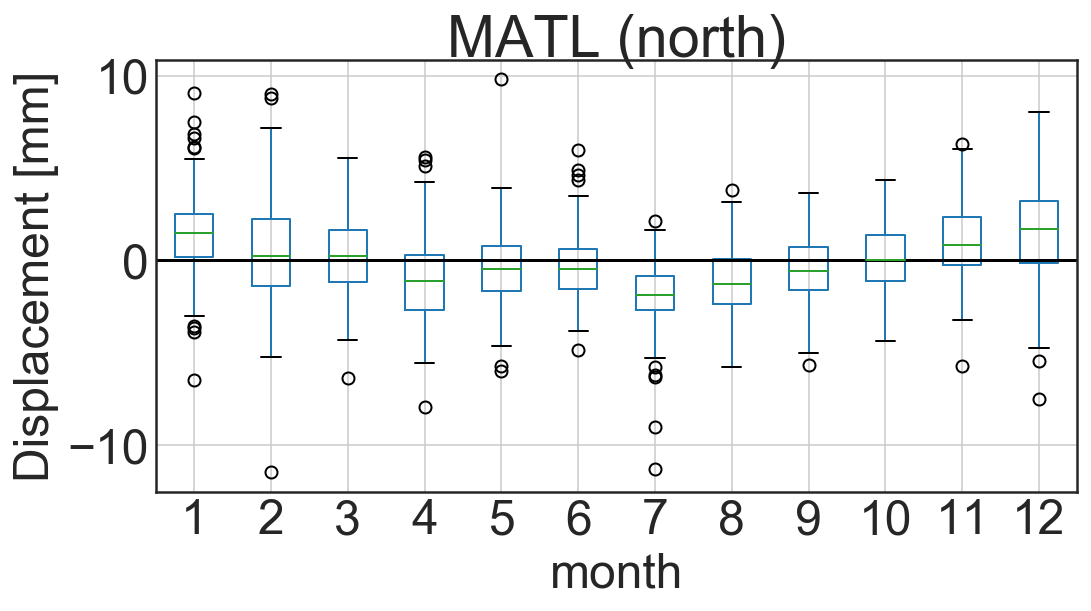

In [39]:
comp = 'north'
tmp['month'] = tmp.index.month
tmp = gps.analysis.do_detrend(tmp, comp, start=0, end=-1)
ax = tmp.boxplot(column=['detrend1_'+comp], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('MATL ({})'.format(comp))
plt.ylabel('Displacement [mm]')

east Rate [mm/yr]=23.463178720179954
RMSE =  2.70766133182


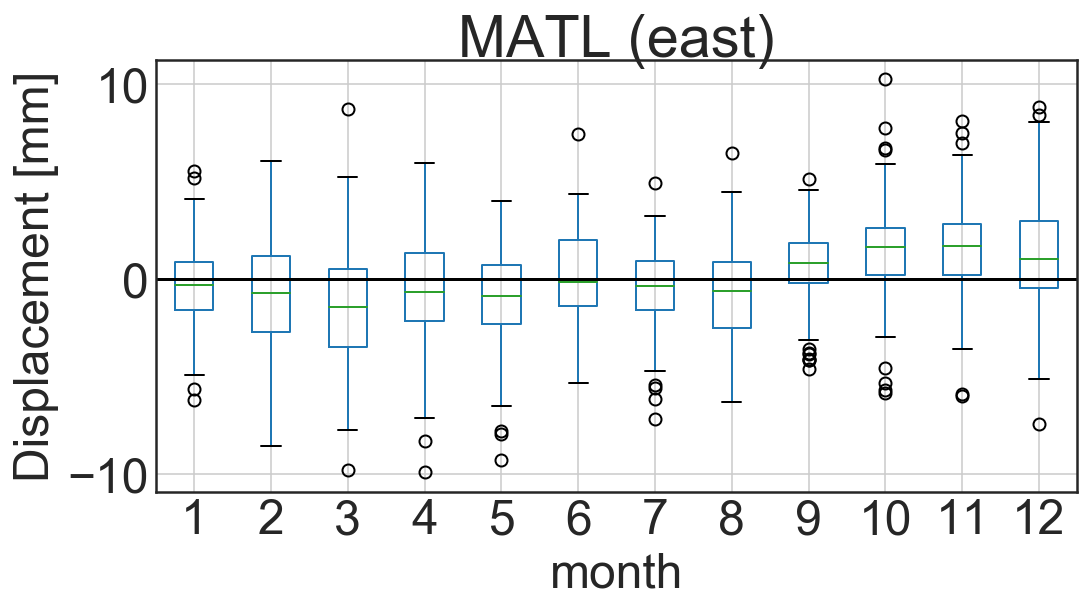

In [40]:
comp = 'east'
tmp['month'] = tmp.index.month
tmp = gps.analysis.do_detrend(tmp, comp, start=0, end=-1)
ax = tmp.boxplot(column=['detrend1_'+comp], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('MATL ({})'.format(comp))
plt.ylabel('Displacement [mm]')

Station moves slightly SouthWest and Down in March/April coinciding with max TWS
And slightly NorthEast and Up in Oct - December

Suggests maybe related to Lake Malawi water level, but KA01 and LIVA are even closer to lake and don't show large displacements.

In [43]:
# Take NaNmean of all detrended vertical components and show boxplot grouped by Month
# Compare Vertical Components
# N-S profile of GPS stations that should show ETS event

sites = seg_sites
start = '2012/06/01'
end = '2017/10/01'
dfAll = pd.DataFrame(index=pd.date_range(start,end) , columns=seg_sites)

comp = 'up'

for i,site in enumerate(sites):
    print(site)
    tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
    tmp = gps.io.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start=start, end=end)
    dfAll[site] = tmp['detrend1_'+comp]


CTPM
CTPM already dowloaded... skipping
up Rate [mm/yr]=5.380823689206396
RMSE =  8.17969360657
KA01
KA01 already dowloaded... skipping
up Rate [mm/yr]=3.7234419216515784
RMSE =  8.88238294693
LIVA
LIVA already dowloaded... skipping
up Rate [mm/yr]=2.34690430575281
RMSE =  9.18966215268
MATL
MATL already dowloaded... skipping
up Rate [mm/yr]=1.9611048682084786
RMSE =  17.7752517046
VWZM
VWZM already dowloaded... skipping
up Rate [mm/yr]=2.4285371455987104
RMSE =  9.34721637372
MBBC
MBBC already dowloaded... skipping
up Rate [mm/yr]=6.268080723324325
RMSE =  10.9158296287
SNGC
SNGC already dowloaded... skipping
up Rate [mm/yr]=1.9776481365643568
RMSE =  10.097858183
MTDK
MTDK already dowloaded... skipping
up Rate [mm/yr]=0.7332158431753051
RMSE =  9.58128894726
TNDC
TNDC already dowloaded... skipping
up Rate [mm/yr]=-0.24488445708552603
RMSE =  7.72286045535
KFNY
KFNY already dowloaded... skipping
up Rate [mm/yr]=2.6448466541443443
RMSE =  7.71117845086
MPIK
MPIK already dowloaded... sk

In [52]:
dfAll.drop('MATL', axis=1, inplace=True) #leave one out
dfAll.head()

CTPM  KA01  LIVA  VWZM  MBBC  SNGC  MTDK  TNDC  KFNY  MPIK
2012-06-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2012-06-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2012-06-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2012-06-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2012-06-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [53]:
dfSum = pd.DataFrame(index=pd.date_range(start,end))
dfSum['err'] = dfAll.apply(np.nanstd, axis=1)
dfSum['ave'] = dfAll.apply(np.nanmean, axis=1)

In [54]:
# Make sure I did this correctly
print(dfAll.loc['2014-08-01'])
print(np.nanmean(dfAll.loc['2014-08-01']))
print(dfSum.loc['2014-08-01'])

CTPM    -6.197276
KA01          NaN
LIVA     5.990100
VWZM   -10.831030
MBBC   -13.794506
SNGC   -17.324721
MTDK    -6.391207
TNDC    -5.665357
KFNY          NaN
MPIK   -10.307820
Name: 2014-08-01 00:00:00, dtype: float64
-8.06522694753
err    6.527298
ave   -8.065227
Name: 2014-08-01 00:00:00, dtype: float64


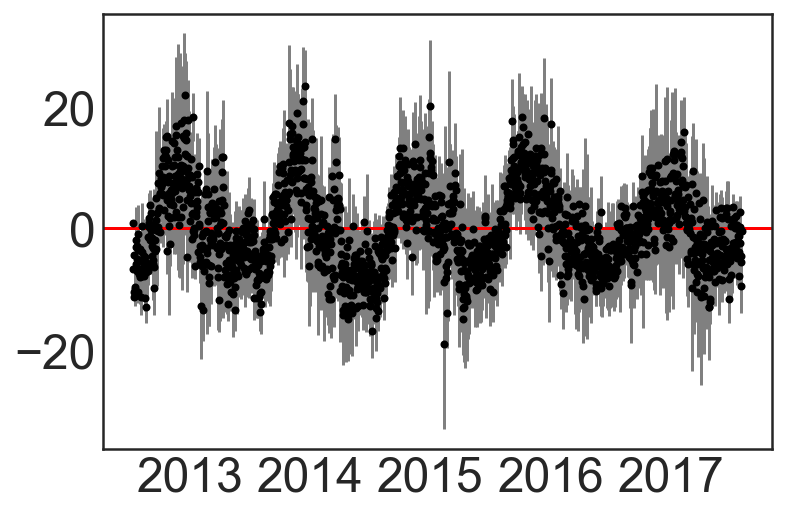

In [55]:
plt.errorbar(dfSum.index, dfSum.ave, dfSum.err, fmt='k.', ecolor='gray')
plt.axhline(0, color='r')

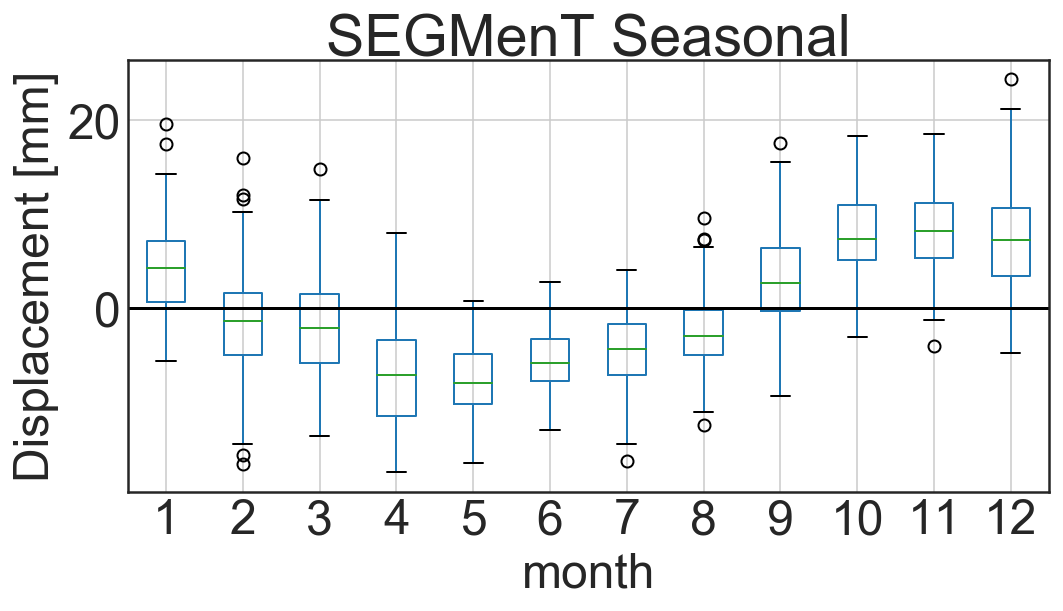

In [47]:
comp = 'up'
dfSum['month'] = dfSum.index.month
ax = dfSum.boxplot(column=['ave'], by='month', figsize=(8,4))
ax.axhline(color='k')
ax.set_title('')
plt.suptitle('SEGMenT Seasonal')
plt.ylabel('Displacement [mm]')

In [175]:
#Do OSU fits for each station'
# create dataframe for storing results
site = 'MATL'


components = ['east','north','up']
iterables = [sites, components]
index = pd.MultiIndex.from_product(iterables, names=['site','comp'])

DF = pd.DataFrame(columns=['t0','xo', 'v', 'b','tj','s1','c1','s2','c2','t1','t2','rmse'], index=index, dtype='f4')

In [176]:
# Test and plot individual station
#df = gps.cull_outliers(df, cols=components) #get rid of really bogus points before fit

tenv3 = gps.io.ungl.download_data(site, refframe='IGS08', overwrite=False)
df = gps.io.ungl.load_tenv3(tenv3)
#tmp = tmp['2010/10/01':'2014/10/01']#specific time range
#df = df.dropna() #necessary for fitting... maybe not?


for comp in components:
    print('fitting {}...'.format(comp))
    # Fit OSU Model
    t0 = df.decyear[0] # intial time [yr]
    x0 = df[comp][0] # initial position [m]
    v = (df[comp][-1] - df[comp][0]) / (df.decyear[-1] - df.decyear[0])  # trend [m/yr]
    b = 0.0  # step jump offset [m]
    tj = gps.io.ungl.decyear2date(df.index[0].strftime('%y%b%d').upper(), inverse=True) #set to first date
    s1 = s2 = c1 = c2 = 0.001 # fourier coefficients [m]
    T1 = 1 # fourier period 1 [yr]
    T2 = 0.5 #fourier period 2 [yr]
    guess = [t0,x0,v,b,tj,s1,c1,s2,c2,T1,T2]

    try:
        #fit,popt,rmse = gps.analysis.invert_osu(df['decyear'], df[comp], guess) #unconstrained
        
        guess = [x0,v,b,s1,c1,s2,c2]
        fit,popt,rmse = gps.analysis.invert_osu_knownEQ(df['decyear'], df[comp], tj, guess)
        
        guess = [t0,x0,v,s1,c1,s2,c2]
        #fit,popt,rmse = gps.analysis.invert_osu_nojumps(df['decyear'], df[comp], guess) #fixed params
        
        df['fit_'+comp] = fit
        # add fixed parameters back into popt
        popt = np.insert(popt, [0,3], [t0,tj])
        popt = np.append(popt, [T1,T2])
        DF.loc[(site,comp),:] = np.append(popt,rmse)
    except Exception as e:
        print(e)
        df['fit_'+comp] = gps.analysis.osu(df.decyear.values, *guess) #plot initial guess
        pass

MATL already dowloaded... skipping
fitting east...
fitting north...
fitting up...


In [177]:
DF

t0          xo          v         b           tj  \
site comp                                                               
MATL east   2012.550293 -619.139221  23.522518 -1.250941  2012.550293   
     north  2012.550293 -733.120239  17.125534 -2.919932  2012.550293   
     up     2012.550293   99.073929   3.284576  1.943702  2012.550293   

                   s1        c1        s2        c2   t1   t2       rmse  
site comp                                                                 
MATL east    1.224281 -0.108237 -0.512845 -0.410718  1.0  0.5   2.509412  
     north   0.407441 -1.229389 -0.416274  0.100626  1.0  0.5   2.188385  
     up     18.406075 -4.488578 -0.291303  3.571829  1.0  0.5  11.319603

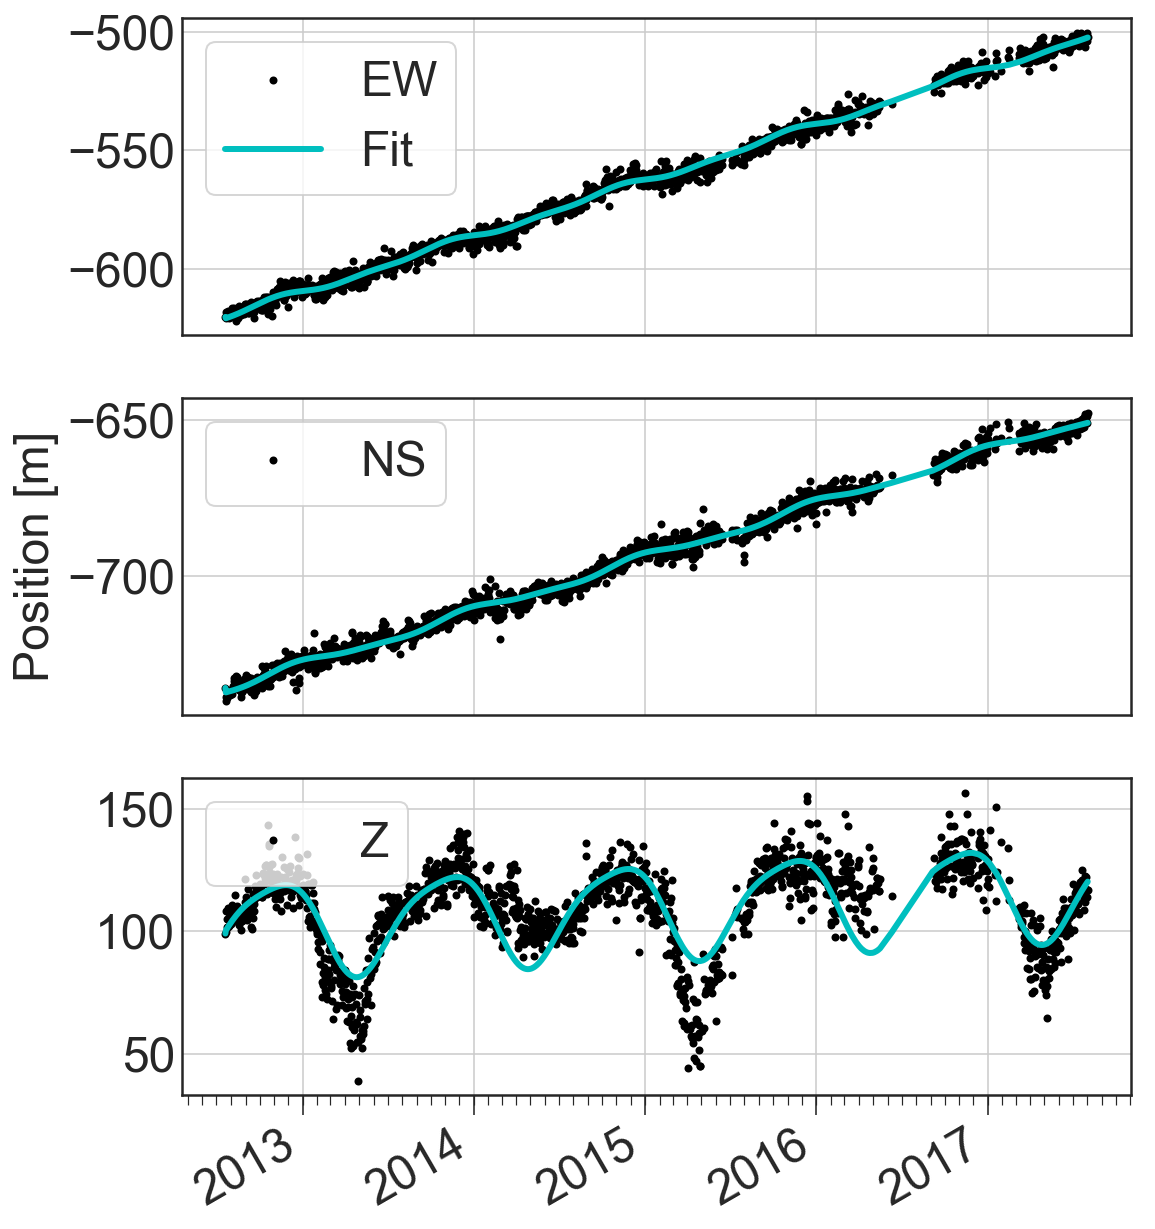

In [99]:
gps.plot.all(df, dfFit=df)

In [193]:
# Check same fit, no jumps
for comp in components:
    print('fitting {}...'.format(comp))
    # Fit OSU Model
    t0 = df.decyear[0] # intial time [yr]
    x0 = df[comp][0] # initial position [m]
    v = (df[comp][-1] - df[comp][0]) / (df.decyear[-1] - df.decyear[0])  # trend [m/yr]
    b = 0.0  # step jump offset [m]
    tj = gps.io.ungl.decyear2date(df.index[0].strftime('%y%b%d').upper(), inverse=True) #set to first date
    s1 = s2 = c1 = c2 = 0.001 # fourier coefficients [m]
    T1 = 1 # fourier period 1 [yr]
    T2 = 0.5 #fourier period 2 [yr]
    guess = [t0,x0,v,b,tj,s1,c1,s2,c2,T1,T2]

    try:
        guess = [x0,v,s1,c1,s2,c2] #NOTE: best fits if T1 & T2 set, otherwise doesn't converge or strange values..
        fit,popt,pcov,rmse = gps.analysis.invert_osu_nojumps(df['decyear'], df[comp], guess) 
        
        df['fit_'+comp] = fit
        # add fixed parameters back into popt
        popt = np.insert(popt, 0, t0)
        popt = np.insert(popt, 3, [b,tj])
        popt = np.append(popt, [T1,T2])
        DF.loc[(site,comp),:] = np.append(popt,rmse)
    except Exception as e:
        print(e)
        df['fit_'+comp] = gps.analysis.osu(df.decyear.values, *guess) #plot initial guess
        pass

fitting east...
fitting north...
fitting up...


In [194]:
DF

t0          xo          v    b           tj         s1  \
site comp                                                                     
MATL east   2012.550293 -620.388672  23.522091  0.0  2012.550293   1.224135   
     north  2012.550293 -736.036804  17.124538  0.0  2012.550293   0.407100   
     up     2012.550293  101.015373   3.285239  0.0  2012.550293  18.406300   

                  c1        s2        c2   t1   t2       rmse  
site comp                                                      
MATL east  -0.107343 -0.512988 -0.409919  1.0  0.5   2.509461  
     north -1.227288 -0.416608  0.102486  1.0  0.5   2.188697  
     up    -4.489976 -0.291082  3.570588  1.0  0.5  11.319630

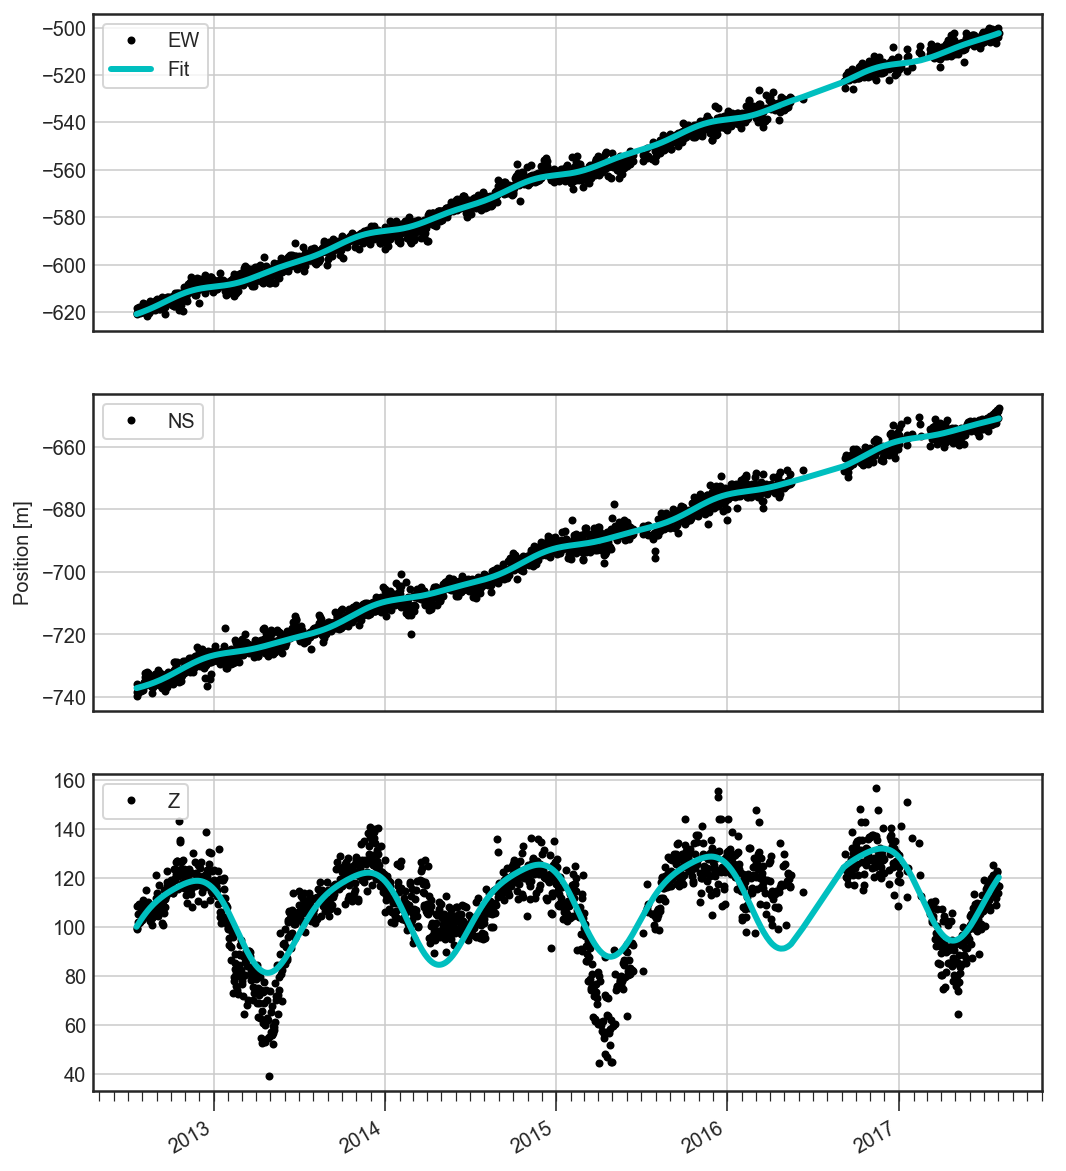

In [195]:
gps.plot.all(df, dfFit=df)

<IPython.core.display.Javascript object>


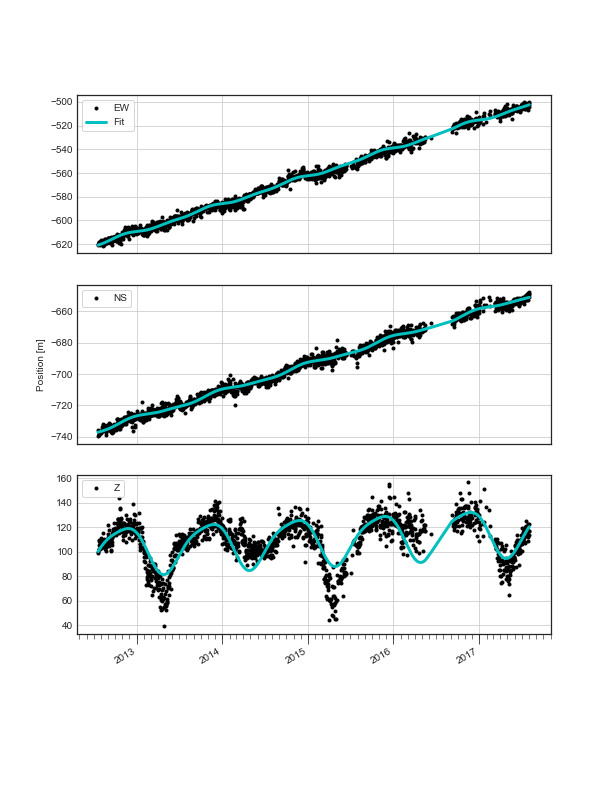

In [199]:
# Check w/ interactive plot
%matplotlib notebook

dfFit = df
columns=['east', 'north','up']


#Plot daily positions
fig, (ax,ax1,ax2) =  plt.subplots(3,1,sharex=True,figsize=(8.5,11))
ax.plot(df.index, df[columns[0]], 'k.', label='EW')
#ax.set_title('NS')

ax1.plot(df.index, df[columns[1]], 'k.', label='NS')
#ax1.set_title('EW')

ax2.plot(df.index, df[columns[2]], 'k.', label='Z')
#ax2.set_title('Z')


ax.plot(dfFit.index, dfFit.fit_east, 'c-' , lw=3, label='Fit')
ax1.plot(dfFit.index.values, dfFit.fit_north.values, 'c-', lw=3)
ax2.plot(dfFit.index.values, dfFit.fit_up.values, 'c-', lw=3)


ax.legend(loc='upper left',frameon=True)
ax1.legend(loc='upper left',frameon=True)
ax2.legend(loc='upper left',frameon=True)
ax1.set_ylabel('Position [m]')

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
for axes in (ax,ax1,ax2):
    axes.xaxis.set_major_locator(years)
    axes.xaxis.set_minor_locator(months) #too much
    axes.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
    axes.grid(True)

plt.tick_params(axis='x', which='minor', length=5, top=False, bottom=True)
plt.tick_params(axis='x', which='major', length=10, top=False, bottom=True)
fig.autofmt_xdate()